In [64]:
%matplotlib inline
import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from fcmeans import FCM
import fasttext
import pandas as pd
import numpy as np
from pymongo import MongoClient
import re
import regex
from collections import Counter
import pyarrow
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import fasttext
import re
import regex
# --- Load FastText Model ---
import fasttext
model = fasttext.load_model("cc.ml.300.bin")  # 300-dimensional vectors
model_detect = fasttext.load_model('lid.176.bin')
from sklearn.metrics import silhouette_score
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from langdetect import detect
from collections import Counter

from langdetect import detect_langs
from collections import Counter
import pandas as pd
import openpyxl
import pickle




import random
import numpy as np
from langdetect import DetectorFactory

random.seed(42)
np.random.seed(42)
DetectorFactory.seed = 42


**Ši funkcija "Apvalo tekstą"**

In [65]:
def extract_clean_words(text):
    special_words = {
        "kcal", "kj", "fr", "ml", "g", "mg", "cm", "kg", "oz", "l", "dl", "i", "c", "of", "j", "od", "js", "x", "a", "gr",
        "is", "b", "jo", "m", "e", "un", "bt", "ms", "lt", "d", "uv", "tv", "lp", "r", "io", "u", "s", "es", "on", "mn",
        "k", "ph", "ab", "in", "y", "nr", "ia", "la", "ii", "n", "mm", "ie", "z", "by", "ri", "as", "or", "ki", "sp", "el",
        "kt", "oo", "pl", "le", "up", "pr", "bd", "pu", "bb", "rb", "pd", "ag", "de", "da", "t", "sa", "kr", "uo", "ea",
        "ha", "p", "al", "co", "mt", "v", "tr", "gl", "vl", "ma", "xs", "jr", "ee", "sm", "bu", "ai", "gi", "ro", "w",
        "ty", "dr", "xx", "ra", "aa", "gg", "aw", "ss", "ul", "oc", "go", "mb", "ed", "sk", "pa", "jg", "h", "yd", "ll",
        "mi", "uk", "vs", "ak", "ti", "pp", "dc", "hz", "re", "ta", "ry", "fe", "na", "li", "no", "bi", "nv", "yo", "ei",
        "xl", "bl", "oh", "mv", "di", "me", "bc", "np", "cp", "uc", "ip", "cj", "ug", "ca", "zn", "ol", "ci", "pc", "ks",
        "hb", "tb", "kl", "cc", "mc", "gb", "pb","µg","μg","spf","nrv"
    }
    text = text.lower()
    text = re.sub(r'\b[a-zA-Z]\d+\b', '', text)
    text = regex.sub(r'[^\p{L}\s]', '', text)
    words = regex.findall(r'\p{L}+', text)
    cleaned_words = [word for word in words if word not in special_words]
    return cleaned_words

def preprocess_text(text):
    words = extract_clean_words(str(text))
    return " ".join(words)

def clean_field_value_column(df):
    df = df.copy()
    df["field_value_clean"] = df["field_value"].apply(preprocess_text)
    return df




**Klasterizavimo funkcijos - Fuzzy ir ne Fuzzy**

In [66]:
def FCM_cluster(df, field_names, num_clusters, m_param):
    """
    Perform FCM clustering and t-SNE dimensionality reduction on embeddings for visualization.

    Parameters:
    - df: The input DataFrame.
    - field_names: List of field names to include for clustering.
    - num_clusters: Number of clusters for FCM.
    - m_param: Fuzziness coefficient for FCM.

    Returns:
    - df_filtered: DataFrame with t-SNE coordinates, cluster labels, soft probabilities, and original columns.
    - fcm: Fitted FCM model.
    """
    if isinstance(field_names, str):
        field_names = [field_names]  # allow single string input too

    # Select rows where field_name is in the provided list
    df_filtered = df[df["field_name"].isin(field_names)].copy()

    # Determine which base columns to keep
    base_columns = ["field_id", "label"] if "label" in df.columns else ["field_id"]

    # Add embedding columns
    embedding_cols = [col for col in df.columns if col.startswith("emb")]
    df_filtered = df_filtered[base_columns + embedding_cols + ["field_name"]]

    # Extract embedding matrix
    X = df_filtered[embedding_cols].values

    # Fit FCM clustering
    fcm = FCM(n_clusters=num_clusters, m=m_param, random_state=42)
    fcm.fit(X)

    # Add hard cluster labels
    df_filtered["fcm_cluster"] = fcm.predict(X)

    # Add soft probabilities
    membership_probs = fcm.soft_predict(X)
    for i in range(num_clusters):
        df_filtered[f"cluster_prob_{i}"] = membership_probs[:, i]

    # Dimensionality reduction: PCA + t-SNE
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_pca)

    df_filtered["tsne_x"] = X_tsne[:, 0]
    df_filtered["tsne_y"] = X_tsne[:, 1]

    return df_filtered, fcm
    
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def KMeans_cluster(df, field_names, num_clusters, initial_centroids=None):
    """
    Perform KMeans clustering and t-SNE visualization.

    Parameters:
    - df: Input DataFrame.
    - field_names: List of field names to cluster.
    - num_clusters: Number of KMeans clusters.
    - initial_centroids: Optional numpy array of shape (num_clusters, num_features)
                         to use as initial cluster centers.

    Returns:
    - df_filtered: DataFrame with t-SNE, cluster labels, and embeddings.
    - kmeans: Fitted KMeans model.
    """
    if isinstance(field_names, str):
        field_names = [field_names]

    df_filtered = df[df["field_name"].isin(field_names)].copy()
    base_columns = ["field_id", "label"] if "label" in df.columns else ["field_id"]

    embedding_cols = [col for col in df.columns if col.startswith("emb")]
    df_filtered = df_filtered[base_columns + embedding_cols + ["field_name"]+ ["field_value"]]

    X = df_filtered[embedding_cols].values

    # Setup KMeans with or without custom initialization
    if initial_centroids is not None:
        print("Using centroids")
        kmeans = KMeans(
            n_clusters=num_clusters,
            init=initial_centroids,
            n_init=1,  # Use exactly the given centroids
            random_state=42,
        )
    else:
        kmeans = KMeans(
            n_clusters=num_clusters,
            init='k-means++',
            n_init=10,
            random_state=42
        )

    df_filtered["kmeans_cluster"] = kmeans.fit_predict(X)

    # Dimensionality reduction
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_pca)

    df_filtered["tsne_x"] = X_tsne[:, 0]
    df_filtered["tsne_y"] = X_tsne[:, 1]

    return df_filtered, kmeans



**Funkcija klasterizavimo grafikams**

In [119]:
def plot_fcm_tsne(df_filtered, test_points_tsne=None, test_labels=None):
    """
    Plot FCM clustering results using t-SNE coordinates.
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    field_name = df_filtered["field_name"].unique()[0]

    # Scatter plot of clustered points
    ax.scatter(
        df_filtered["tsne_x"], df_filtered["tsne_y"],
        c=df_filtered["fcm_cluster"], cmap="viridis", alpha=0.4, s=20,
        label="Clustered points"
    )

    # Optional overlay: test points
    if test_points_tsne is not None:
        if test_labels is None:
            ax.scatter(test_points_tsne[:, 0], test_points_tsne[:, 1],
                       c='red', marker='x', s=100, label='Test points')
        else:
            test_labels = list(test_labels)
            unique_labels = sorted(set(test_labels))
            markers = ['o', '^', 's', 'D', '*', 'X']
            colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
            for i, label in enumerate(unique_labels):
                mask = [l == label for l in test_labels]
                ax.scatter(
                    test_points_tsne[mask, 0], test_points_tsne[mask, 1],
                    c=colors[i % len(colors)], marker=markers[i % len(markers)],
                    s=100, label=f"Test label {label}"
                )

    ax.set_title(f"{field_name} FCM Klasterizacija", fontsize=14)
    ax.set_xlabel("t-SNE X")
    ax.set_ylabel("t-SNE Y")
    ax.legend()
    plt.tight_layout()
    plt.show()



def plot_kmeans_tsne(df_filtered, test_points_tsne=None, test_labels=None):
    """
    Plot KMeans clustering results using t-SNE coordinates.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    field_name = df_filtered["field_name"].unique()[0]

    ax.scatter(
        df_filtered["tsne_x"], df_filtered["tsne_y"],
        c=df_filtered["kmeans_cluster"], cmap="tab20", alpha=0.6,
        s=30, edgecolor='k', linewidth=0.3, label="Klasterizuoti taškai"
    )

    if test_points_tsne is not None:
        if test_labels is None:
            ax.scatter(
                test_points_tsne[:, 0], test_points_tsne[:, 1],
                c='black', marker='x', s=80, linewidth=1.5, label='Test points'
            )
        else:
            test_labels = list(test_labels)
            unique_labels = sorted(set(test_labels))
            markers = ['o', '^', 's', 'D', '*', 'X']
            colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']
            for i, label in enumerate(unique_labels):
                mask = [l == label for l in test_labels]
                ax.scatter(
                    test_points_tsne[mask, 0], test_points_tsne[mask, 1],
                    c=colors[i % len(colors)], marker=markers[i % len(markers)],
                    s=90, edgecolor='k', linewidth=0.8, label=f"Test label {label}"
                )

    ax.set_title(f"{field_name} KMeans Klasterizacija", fontsize=14)
    ax.set_xlabel("t-SNE X")
    ax.set_ylabel("t-SNE Y")
    ax.legend()
    plt.tight_layout()
    plt.show()


**Funkcija padaryti FastText vektorines reprezentacijas**

In [16]:
# --- Embed Function ---
#def get_fasttext_embeddings(texts):
#    clean_texts = [text.replace('\n', ' ').replace('\r', ' ') for text in texts]
#    return [model.get_sentence_vector(text).astype(np.float16) for text in clean_texts]

# --- Main Pipeline ---
#def embed_cleaned_dataframe(df, batch_size=32, output_file="embedded_data_fasttext_cleaned_fp16_CLEAN.csv"):
#    df = clean_field_value_column(df)
#    field_values = df["field_value_clean"].astype(str).tolist()
    
#    all_embeddings = []
#    for i in range(0, len(field_values), batch_size):
#        batch_texts = field_values[i : i + batch_size]
#        batch_embeddings = get_fasttext_embeddings(batch_texts)
#        print(f"Processed {i + len(batch_texts)} / {len(field_values)}")
#        all_embeddings.append(batch_embeddings)

#    embeddings = np.vstack(all_embeddings).astype(np.float16)
#    embeddings_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
    
#    # Merge with original metadata
#    df_final = pd.concat([
#        df[["_id", "retailer", "country_name", "field_name", "field_id", "language_code", "field_value_clean"]].reset_index(drop=True),
#        embeddings_df
#    ], axis=1)
    
#    df_final.to_csv(output_file, index=False)
#    print(f"✅ Saved to {output_file}")
#    return df_final
"""
# Connect to MongoDB
#client = MongoClient("mongodb://localhost:27017/")  # Replace with your connection string
#db = client["kursinis"]  # Replace with your database name
#collection = db["data1"]  # Replace with your collection name

# Fetch all necessary fields
data = collection.find({}, {
    "_id":1,
    "retailer": 1,
    "country_name": 1,
    "field_name": 1,
    "field_id": 1,
    "field_value": 1,
    "language_code": 1
})

# Convert to DataFrame
df = pd.DataFrame(list(data))

# Run the full pipeline
df_embedded = embed_cleaned_dataframe(df)
"""

'\n# Connect to MongoDB\n#client = MongoClient("mongodb://localhost:27017/")  # Replace with your connection string\n#db = client["kursinis"]  # Replace with your database name\n#collection = db["data1"]  # Replace with your collection name\n\n# Fetch all necessary fields\ndata = collection.find({}, {\n    "_id":1,\n    "retailer": 1,\n    "country_name": 1,\n    "field_name": 1,\n    "field_id": 1,\n    "field_value": 1,\n    "language_code": 1\n})\n\n# Convert to DataFrame\ndf = pd.DataFrame(list(data))\n\n# Run the full pipeline\ndf_embedded = embed_cleaned_dataframe(df)\n'

**Atskiras Kanados duomenu sutvarkymas - naudojama darbo eigoje, rezutlatai tiriami is pilno duomenu apdorojimo**

In [17]:
"""
from pymongo import MongoClient
import pandas as pd

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["kursinis"]
collection = db["data1"]

# Query, sort by field_id ascending, limit 250
cursor = collection.find(
    {"country_name": "Canada", "field_name": "name"}
).sort("field_id", -1).limit(951)

# Convert to DataFrame
df_canada_name_bottom951 = pd.DataFrame(list(cursor))
df_canada_top1200=pd.read_csv("output_canada_name.csv")
df_canada_nutr=pd.read_csv("output_canada_nutr.csv")
df_canada_br=pd.read_csv("output_canada_br.csv")

# Query, sort by field_id ascending, limit 250
cursor = collection.find(
    {"country_name": "Canada", "field_name": "description"}
).sort("field_id", -1).limit(700)

df_canada_desc_bottom700 = pd.DataFrame(list(cursor))
df_canada_desc_top=pd.read_csv("output_canada_desc.csv")

df_combined_canada = pd.concat([df_canada_name_bottom951, df_canada_top1200,df_canada_nutr,df_canada_br,df_canada_desc_bottom700,df_canada_desc_top], ignore_index=True)

df_combined_canada_clean=clean_field_value_column(df_combined_canada)

print(df_combined_canada_clean.head())

# Load FastText multilingual model
model = fasttext.load_model('cc.ml.300.bin')

field_values = df_combined_canada_clean["field_value"].astype(str).tolist()

batch_size = 32
all_embeddings = []

def get_fasttext_embeddings(texts):
    clean_texts = [text.replace('\n', ' ').replace('\r', ' ') for text in texts]
    return [model.get_sentence_vector(text).astype(np.float16) for text in clean_texts]


# Process in batches
for i in range(0, len(field_values), batch_size):
    batch_texts = field_values[i : i + batch_size]
    batch_embeddings = get_fasttext_embeddings(batch_texts)
    print(f"Processed {i} rows")
    all_embeddings.append(batch_embeddings)

# Convert to float16 NumPy array
embeddings = np.vstack(all_embeddings).astype(np.float16)

# Create DataFrame and merge
embeddings_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
df_combined_canada_clean_emb = pd.concat([df_combined_canada_clean[["_id", "retailer", "country_name", "field_name", "field_id", "language_code","label", "field_value"]].reset_index(drop=True), embeddings_df], axis=1)
df_combined_canada_clean_emb["_id"] = df_combined_canada_clean_emb["_id"].astype(str)
# Save to CSV
df_combined_canada_clean_emb.to_parquet("embedded_data_fasttext_canada_clean_fp16.csv", index=False)

"""

'\nfrom pymongo import MongoClient\nimport pandas as pd\n\n# Connect to MongoDB\nclient = MongoClient("mongodb://localhost:27017/")\ndb = client["kursinis"]\ncollection = db["data1"]\n\n# Query, sort by field_id ascending, limit 250\ncursor = collection.find(\n    {"country_name": "Canada", "field_name": "name"}\n).sort("field_id", -1).limit(951)\n\n# Convert to DataFrame\ndf_canada_name_bottom951 = pd.DataFrame(list(cursor))\ndf_canada_top1200=pd.read_csv("output_canada_name.csv")\ndf_canada_nutr=pd.read_csv("output_canada_nutr.csv")\ndf_canada_br=pd.read_csv("output_canada_br.csv")\n\n# Query, sort by field_id ascending, limit 250\ncursor = collection.find(\n    {"country_name": "Canada", "field_name": "description"}\n).sort("field_id", -1).limit(700)\n\ndf_canada_desc_bottom700 = pd.DataFrame(list(cursor))\ndf_canada_desc_top=pd.read_csv("output_canada_desc.csv")\n\ndf_combined_canada = pd.concat([df_canada_name_bottom951, df_canada_top1200,df_canada_nutr,df_canada_br,df_canada_desc

**Vidutiniu vektor. rep. gaunanti funkcija - naudinga centroidams pusiau priziurimui klasterizavimui**

In [68]:
def get_average_embeddings(df, country_name: str, field_names: list):
    # Filter by country
    df_filtered = df[df["country_name"] == country_name]

    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith("emb_")]

    # Group and average for each field_name
    result_rows = []
    for field in field_names:
        group_df = df_filtered[df_filtered["field_name"] == field]
        if group_df.empty:
            print(f"No data found for: {country_name} / {field}")
            continue
        avg_vector = group_df[embedding_cols].mean().to_frame().T
        avg_vector["country_name"] = country_name
        avg_vector["field_name"] = field
        result_rows.append(avg_vector)

    # Combine all rows
    result_df = pd.concat(result_rows, ignore_index=True)
    return result_df

"""
# --- Step 1: Extract representative centroids ---
embedding_cols = [col for col in df_fasttext.columns if col.startswith("emb_")]

# Get UK "description" centroid
uk_reps = get_average_embeddings(df_fasttext, "UK", ["description"])
uk_description_centroid = uk_reps.loc[uk_reps["field_name"] == "description", embedding_cols].values.squeeze()

# Get Lithuania "description" cluster 1 centroid
cluster_1_centroid = (
    df_clustered[
        (df_clustered["country_name"] == "Lithuania") &
        (df_clustered["field_name"] == "description") &
        (df_clustered["kmeans_cluster"] == 1)
    ][embedding_cols]
    .mean()
    .values
)

# --- Step 2: Use both centroids in KMeans ---
init_centroids = np.vstack([uk_description_centroid, cluster_1_centroid])

Now you can call with 2 centroids
"""

'\n# --- Step 1: Extract representative centroids ---\nembedding_cols = [col for col in df_fasttext.columns if col.startswith("emb_")]\n\n# Get UK "description" centroid\nuk_reps = get_average_embeddings(df_fasttext, "UK", ["description"])\nuk_description_centroid = uk_reps.loc[uk_reps["field_name"] == "description", embedding_cols].values.squeeze()\n\n# Get Lithuania "description" cluster 1 centroid\ncluster_1_centroid = (\n    df_clustered[\n        (df_clustered["country_name"] == "Lithuania") &\n        (df_clustered["field_name"] == "description") &\n        (df_clustered["kmeans_cluster"] == 1)\n    ][embedding_cols]\n    .mean()\n    .values\n)\n\n# --- Step 2: Use both centroids in KMeans ---\ninit_centroids = np.vstack([uk_description_centroid, cluster_1_centroid])\n\nNow you can call with 2 centroids\n'

**UK duomenų paruosimas - naudojamas logistinei regresijai apmokyti, reprezentatyvi imtis**

In [ ]:
""""
def sample_english_representatives(df, country_name="United Kingdom", fields=None, seed=123):
    """
    """
    Sample one row per (retailer, field_name) iteratively to create a balanced English dataset.
    """
    """
    if fields is None:
        fields = ["description", "name", "breadcrumbs", "nutritional_info"]

    df_uk = df[
        (df["country_name"] == country_name) & 
        (df["field_name"].isin(fields))
    ].copy().sort_values(by=["retailer"]).reset_index(drop=True)

    final_list = []
    df_remaining = df_uk.copy()
    random.seed(seed)

    while not df_remaining.empty:
        sampled_rows = []
        grouped = df_remaining.groupby(["retailer", "field_name"])
        for (retailer, field_name), group_df in grouped:
            if not group_df.empty:
                chosen_row = group_df.sample(n=1, random_state=random.randint(0, 10000))
                sampled_rows.append(chosen_row)

        sampled_df = pd.concat(sampled_rows)
        final_list.append(sampled_df)

        df_remaining = pd.concat([df_remaining, sampled_df, sampled_df]).drop_duplicates(keep=False)

    final_df = pd.concat(final_list).reset_index(drop=True)
    return final_df

# Run once and save
sampled_uk_df = sample_english_representatives(df_fasttext)
sampled_uk_df.to_parquet("english_representatives.parquet", index=False)
"""

**Funkcija gauti dažniausius žodžius**

In [69]:
def get_top_words_from_dataframe(df, field_column="field_value", top_n=30, min_word_length=4):
    all_words = []

    for text in df[field_column]:
        if not isinstance(text, str):
            continue  # Skip None or non-string values

        try:
            words = extract_clean_words(text)
            all_words.extend([word for word in words if len(word) >= min_word_length])
        except Exception:
            continue  # Skip anything that breaks

    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)


**Isikeliame duomenis (negalime jais dalintis)**

In [ ]:
df_combined_lithuania_clean_emb = pd.read_parquet("embedded_data_fasttext_Lithuania_clean_fp16.csv")
df_binary_ml = df_combined_lithuania_clean_emb.copy()
df_binary_ml["label"] = df_binary_ml["label"].apply(lambda x: 1 if x == 2 else x)

df_fasttext= pd.read_csv("embedded_data_fasttext_cleaned_fp16_CLEAN.csv", engine="pyarrow")

df_fasttext.rename(columns={"field_value_clean": "field_value"}, inplace=True)

df_combined_canada_clean_emb=pd.read_parquet("embedded_data_fasttext_Canada_clean_fp16.csv")

df_english_rep=pd.read_parquet("english_representatives.parquet")


# 1. Subset Lithuania from df_fasttext
df_lithuania_fasttext = df_fasttext[df_fasttext["country_name"] == "Lithuania"].copy()

# 2. Join only the 'label' column from df_binary_ml using field_id
df_lithuania_labeled = df_lithuania_fasttext.merge(
    df_binary_ml[["field_id", "label"]],
    on="field_id",
    how="left"
)


# 1. Subset Canada from df_fasttext
df_canada_fasttext = df_fasttext[df_fasttext["country_name"] == "Canada"].copy()

# 2. Join only the 'label' column from df_combined_canada_clean_emb using field_id
df_canada_labeled = df_canada_fasttext.merge(
    df_combined_canada_clean_emb[["field_id", "label"]],
    on="field_id",
    how="left"
)



**Funkcija Kmeans klasterizavimui paleisti ir naudoti rezultatus tolimesnei eigai**


In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

def run_kmeans_clustering(df, field_to_cluster, num_clusters=2, plot=True, initial_centroids=None, show_confusion=False):
    """
    Runs KMeans clustering, detects language of top words in each cluster.
    
    Parameters:
    - show_confusion: If True and 'label' exists, print confusion matrix.

    Returns:
    - df_cluster_0, df_cluster_1: Clustered DataFrames
    - df_cluster0_top25, df_cluster1_top25: Top words as sentences
    - should_continue: True if clusters are clearly separable
    - lang0, lang1: Detected languages for cluster 0 and 1
    """
    df_clustered, fcm_model = KMeans_cluster(df, field_to_cluster, num_clusters, initial_centroids)

    if plot:
        plot_kmeans_tsne(df_clustered)

    X = df_clustered[[col for col in df_clustered.columns if col.startswith("emb")]].values
    labels = df_clustered["kmeans_cluster"].values
    score = silhouette_score(X, labels)
    print(f"Silhouette index: {score:.3f}")

    if show_confusion and "label" in df_clustered.columns:
        true_labels = df_clustered["label"].values.astype(int)
        cm = confusion_matrix(true_labels, labels)

        # Use Hungarian algorithm to align clusters with labels
        row_ind, col_ind = linear_sum_assignment(-cm)
        aligned_cm = cm[:, col_ind]

        accuracy = np.trace(aligned_cm) / np.sum(aligned_cm)
        print("Confusion Matrix (aligned):")
        print(aligned_cm)
        print(f"Accuracy: {accuracy:.2%}\n")

    top_word_sentences = {}
    lang_info = {}

    for cluster_id in range(num_clusters):
        cluster_df = df_clustered[df_clustered["kmeans_cluster"] == cluster_id].copy()
        top_words = get_top_words_from_dataframe(cluster_df, field_column="field_value")
        top_word_sentence = " ".join([word for word, _ in top_words])
        top_word_sentences[cluster_id] = top_word_sentence

        try:
            langs = detect_langs(top_word_sentence)
            if langs:
                detected_lang = langs[0].lang
                confidence = langs[0].prob
            else:
                detected_lang = "unknown"
                confidence = 0.0
        except Exception:
            detected_lang = "unknown"
            confidence = 0.0

        lang_info[cluster_id] = (detected_lang, confidence)

    lang0, conf0 = lang_info[0]
    lang1, conf1 = lang_info[1]

    def is_confident_english(lang, conf):
        return lang == "en" and conf > 0.5

    def is_confident_non_english(lang, conf):
        return lang != "en" and lang != "unknown" and conf > 0.2

    should_continue = (
        (is_confident_english(lang0, conf0) and is_confident_non_english(lang1, conf1)) or
        (is_confident_english(lang1, conf1) and is_confident_non_english(lang0, conf0))
    )

    df_cluster_0 = df_clustered[df_clustered["kmeans_cluster"] == 0].copy()
    df_cluster_1 = df_clustered[df_clustered["kmeans_cluster"] == 1].copy()
    df_cluster0_top25 = top_word_sentences[0]
    df_cluster1_top25 = top_word_sentences[1]

    return (
        df_cluster_0,
        df_cluster_1,
        df_cluster0_top25,
        df_cluster1_top25,
        should_continue,
        lang0,
        lang1
    )



**Funkcija logistinei regresijai apmokyti**

In [72]:
def train_balanced_language_classifier(df_english_rep, df_non_english_cluster, field_name, embedding_prefix="emb_"):
    """
    Trains a binary classifier to distinguish English from non-English data for a specific field.

    Parameters:
    - df_english_rep (pd.DataFrame): Full pre-sampled English representatives.
    - df_non_english_cluster (pd.DataFrame): Non-English cluster (assumed to be for one field).
    - field_name (str): The field to filter English reps (e.g., 'description').
    - embedding_prefix (str): Prefix used for embedding columns.

    Returns:
    - clf: Trained logistic regression classifier.
    - embedding_cols: List of used embedding columns.
    """

    # Filter English reps for this specific field_name
    df_eng_filtered = df_english_rep[df_english_rep["field_name"] == field_name].copy()

    if df_eng_filtered.empty:
        raise ValueError(f"No English representatives found for field '{field_name}'.")

    # Adjust sample sizes to be balanced
    n_eng = len(df_eng_filtered)
    n_non_eng = len(df_non_english_cluster)

    if n_non_eng > n_eng:
        df_eng_sampled = df_eng_filtered
        df_non_eng_sampled = df_non_english_cluster.sample(n=n_eng, random_state=42)
    else:
        df_eng_sampled = df_eng_filtered.sample(n=n_non_eng, random_state=42)
        df_non_eng_sampled = df_non_english_cluster

    # Label the data
    df_eng_sampled["label"] = 0  # English
    df_non_eng_sampled = df_non_eng_sampled.copy()
    df_non_eng_sampled["label"] = 1  # Non-English

    # Combine datasets
    df_combined = pd.concat([df_eng_sampled, df_non_eng_sampled], ignore_index=True)
    print(df_combined["label"].value_counts())

    # Select embedding features
    embedding_cols = [col for col in df_combined.columns if col.startswith(embedding_prefix)]
    X = df_combined[embedding_cols].values
    y = df_combined["label"].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["English", "Non-English"]))

    return clf, embedding_cols


**Funkcija spejimus daryti su logistine regresija**

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

def evaluate_confident_predictions_on_df(clf, df, low=0.3, high=0.7):
    embedding_cols = [col for col in df.columns if col.startswith("emb")]
    X_test = df[embedding_cols].values

    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred_certain = -1 * np.ones_like(y_proba, dtype=int)
    y_pred_certain[y_proba > high] = 1
    y_pred_certain[y_proba < low] = 0
    certain_mask = y_pred_certain != -1

    print(f"Number of certain predictions: {certain_mask.sum()} / {len(y_proba)}")

    df_with_preds = df.copy()
    df_with_preds["y_proba"] = y_proba
    df_with_preds["y_pred_certain"] = y_pred_certain
    df_with_preds["certain"] = certain_mask

    if "label" in df.columns:
        df_eval = df_with_preds[certain_mask].copy()
        df_eval["label"] = df_eval["label"].astype(int)
        df_eval["predicted"] = df_eval["y_pred_certain"]

        # Always specify labels for confusion_matrix
        conf_matrix = confusion_matrix(df_eval["label"], df_eval["predicted"], labels=[0, 1])
        conf_df = pd.DataFrame(
            conf_matrix,
            index=["True 0", "True 1"],
            columns=["Pred 0", "Pred 1"]
        )
        print("Confusion Matrix:")
        print(conf_df)

        unique_classes = np.unique(df_eval["label"])
        if len(unique_classes) == 2:
            print("\nClassification Report:")
            print(classification_report(
                df_eval["label"],
                df_eval["predicted"],
                digits=4,
                target_names=["English", "Non-English"]
            ))
        else:
            print(f"\nOnly one class present ({unique_classes[0]}). Skipping classification report.")

    df_uncertain = df_with_preds[~certain_mask].copy()
    return df_with_preds, df_uncertain


**Fastext neuztikrintiems spėjimams**


In [74]:
def predict_fasttext_confident(df_uncertain, model_fasttext, conf_threshold=0.5):
    """
    Predicts language using FastText. Updates 'language_code_predicted':
    - If confidence >= threshold → assign predicted lang
    - Else → assign 'uncertain'
    """
    langs = []
    confs = []

    for text in df_uncertain["field_value"]:
        try:
            prediction = model_fasttext.predict(text)
            lang = prediction[0][0].replace("__label__", "")
            conf = prediction[1][0]
        except Exception:
            lang = "unknown"
            conf = 0.0

        langs.append(lang if conf >= conf_threshold else "uncertain")
        confs.append(conf)

    df_uncertain["fasttext_lang"] = langs
    df_uncertain["fasttext_conf"] = confs
    df_uncertain["language_code_predicted"] = langs

    return df_uncertain


**Logika apjungianti pagalbines funkcijas - naudojama didžiajai daliai šalių**

In [93]:
def process_country_language_labeling(
    df_fasttext,
    country,
    field_name,
    df_english_rep,
    model_detect,
    country_language_counts
):
    """
    Runs the language labeling pipeline for a given country and field_name.
    Updates 'language_code_predicted' column directly in df_fasttext.
    If clustering is problematic, returns (country, field_name) as problematic.

    Args:
        df_fasttext: Full DataFrame
        country: Country name (str)
        field_name: Field to process (str)
        df_english_rep: Representative English rows for LR training
        model_detect: FastText model
        country_language_counts: Precomputed DataFrame with (country_name, language_code, counts)

    Returns:
        df_fasttext: updated DataFrame
        problematic_cluster_info: (country, field_name) if clustering failed, else None
    """
    if "language_code_predicted" not in df_fasttext.columns:
        df_fasttext["language_code_predicted"] = "unknown"

    df = df_fasttext[df_fasttext["country_name"] == country].copy()

    (
        df0,
        df1,
        top25_0,
        top25_1,
        should_continue,
        lang0,
        lang1
    ) = run_kmeans_clustering(df, field_name, 2, plot=True)

    problematic_cluster_info = None

    if should_continue:
        print(f"Proceeding with logistic regression. English cluster: {'0' if lang0 == 'en' else '1'}")

        # Assign clusters
        english_cluster = df0 if lang0 == 'en' else df1
        non_english_cluster = df1 if lang0 == 'en' else df0
        detected_non_english_lang = lang1 if lang0 == 'en' else lang0

        # Get most common non-English language code for the country
        lang_counts = country_language_counts[country_language_counts["country_name"] == country].sort_values("counts", ascending=False)
        top_langs = lang_counts["language_code"].tolist()
        most_common_non_en = next((lang for lang in top_langs if lang != 'en'), 'unknown')

        non_english_lang = most_common_non_en if most_common_non_en != 'unknown' else detected_non_english_lang

        # STEP 1: Label non-English cluster
        df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

        # STEP 2: Train LR and label confident predictions
        clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name=field_name)

        df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, 0.3, 0.7)

        # Label confident English
        conf_eng = df_preds[df_preds["y_pred_certain"] == 0]
        df.loc[conf_eng.index, "language_code_predicted"] = "en"

        # Label confident Non-English
        conf_non_eng = df_preds[df_preds["y_pred_certain"] == 1]
        df.loc[conf_non_eng.index, "language_code_predicted"] = non_english_lang

        # For uncertain cases fallback to FastText
        df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
        df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]

    else:
        print(f"Problematic clustering — Cluster 0: {lang0}, Cluster 1: {lang1}")
        problematic_cluster_info = (country, field_name)

    df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]

    print(df_fasttext["language_code_predicted"].value_counts(dropna=False))

    return df_fasttext, problematic_cluster_info


**Logika kviečianti apjungta funkciją didžiajai daliai šalių - gražina ir vertes, kur reikalingas žmogaus įsiterpimas**

In [76]:
countries = [
    "Algeria",
    "Argentina",
    "Austria",
    "Belarus",
    "Bolivia",
    "Bosnia_Herzegovina",
    "Bulgaria",
    "Cambodia",
    "Cameroon",
    "Chile",
    "China",
    "Colombia",
    "Costa Rica",
    "Croatia",
    "Czech Republic",
    "Denmark",
    "Dominic Republic",
    "Ecuador",
    "Egypt",
    "Estonia",
    "Finland",
    "Georgia",
    "Greece",
    "Guatemala",
    "Hong Kong, China",
    "Hungary",
    "Indonesia",
    "Ireland",
    "Israel",
    "Italy",
    "Japan",
    "Kazakhstan",
    "Latvia",
    "Lithuania",
    "Mexico",
    "Myanmar",
    "Netherlands",
    "Norway",
    "Panama",
    "Peru",
    "Poland",
    "Portugal",
    "Romania",
    "Russia",
    "Saudi Arabia",
    "Serbia",
    "Slovakia",
    "Slovenia",
    "South Korea",
    "Sweden",
    "Taiwan",
    "Thailand",
    "Tunisia",
    "Turkey",
    "Uruguay",
    "Uzbekistan",
    "Vietnam"
]

problematic_clusters = []

for country in countries:
    print(f"\n=== Processing country: {country} ===")
    
    # Get unique field names for this country
    country_df = df_fasttext[df_fasttext["country_name"] == country]
    unique_fields = country_df["field_name"].unique()
    
    for field in unique_fields:
        print(f"\nProcessing field: {field} for country: {country}")
        df_fasttext, problem = process_country_language_labeling(
            df_fasttext, country, field, df_english_rep, model_detect, country_language_counts
        )
        if problem is not None:
            problematic_clusters.append(problem)

print("\nProblematic clusters summary (country, field):")
print(problematic_clusters)



=== Processing country: Algeria ===

Processing field: name for country: Algeria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.092
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown    336836
Name: count, dtype: int64

Processing field: description for country: Algeria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.412
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown    336836
Name: count, dtype: int64

Processing field: breadcrumbs for country: Algeria
Silhouette index: 0.143
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown    336836
Name: count, dtype: int64

=== Processing country: Argentina ===

Processing field: description for country: Argentina


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.501
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown    336836
Name: count, dtype: int64

Processing field: name for country: Argentina


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.097
Proceeding with logistic regression. English cluster: 1
label
0    442
1    442
Name: count, dtype: int64
Confusion Matrix:
[[80  9]
 [ 1 87]]

Classification Report:
              precision    recall  f1-score   support

     English       0.99      0.90      0.94        89
 Non-English       0.91      0.99      0.95        88

    accuracy                           0.94       177
   macro avg       0.95      0.94      0.94       177
weighted avg       0.95      0.94      0.94       177

Number of certain predictions: 206 / 408
language_code_predicted
unknown      335986
es              504
en              205
uncertain       120
fr               11
pt                4
it                2
pl                2
de                1
cs                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Argentina


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.074
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      335986
es              504
en              205
uncertain       120
fr               11
pt                4
it                2
pl                2
de                1
cs                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Argentina
Silhouette index: 0.614


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      335986
es              504
en              205
uncertain       120
fr               11
pt                4
it                2
pl                2
de                1
cs                1
Name: count, dtype: int64

=== Processing country: Austria ===

Processing field: breadcrumbs for country: Austria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.088
Problematic clustering — Cluster 0: de, Cluster 1: de
language_code_predicted
unknown      335986
es              504
en              205
uncertain       120
fr               11
pt                4
it                2
pl                2
de                1
cs                1
Name: count, dtype: int64

Processing field: name for country: Austria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.085
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      335986
es              504
en              205
uncertain       120
fr               11
pt                4
it                2
pl                2
de                1
cs                1
Name: count, dtype: int64

Processing field: description for country: Austria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.270
Problematic clustering — Cluster 0: de, Cluster 1: de
language_code_predicted
unknown      335986
es              504
en              205
uncertain       120
fr               11
pt                4
it                2
pl                2
de                1
cs                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Austria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.504
Proceeding with logistic regression. English cluster: 1
label
0    224
1    224
Name: count, dtype: int64
Confusion Matrix:
[[45  0]
 [ 0 45]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        45
 Non-English       1.00      1.00      1.00        45

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Number of certain predictions: 26 / 26
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

=== Processing country: Belarus ===

Processing field: description for country: Belarus


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.537
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

Processing field: name for country: Belarus


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.108
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Belarus


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.240
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Belarus
Silhouette index: 0.877
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

=== Processing country: Bolivia ===


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Processing field: breadcrumbs for country: Bolivia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.095
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

Processing field: name for country: Bolivia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.107
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

Processing field: description for country: Bolivia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.383
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      335736
es              504
en              231
de              225
uncertain       120
fr               11
pt                4
it                2
pl                2
cs                1
Name: count, dtype: int64

=== Processing country: Bosnia_Herzegovina ===

=== Processing country: Bulgaria ===

Processing field: description for country: Bulgaria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.519
Proceeding with logistic regression. English cluster: 1
label
0    296
1    296
Name: count, dtype: int64
Confusion Matrix:
[[60  0]
 [ 0 59]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        60
 Non-English       1.00      1.00      1.00        59

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

Number of certain predictions: 45 / 54
language_code_predicted
unknown      335386
es              504
bg              297
en              275
de              225
uncertain       128
fr               11
pt                4
it                3
pl                2
cs                1
Name: count, dtype: int64

Processing field: name for country: Bulgaria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.140
Proceeding with logistic regression. English cluster: 0
label
0    160
1    160
Name: count, dtype: int64
Confusion Matrix:
[[31  1]
 [ 0 32]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.97      0.98        32
 Non-English       0.97      1.00      0.98        32

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.98      0.98      0.98        64

Number of certain predictions: 122 / 190
language_code_predicted
unknown      335036
es              504
bg              474
en              401
de              225
uncertain       163
fr               12
it                6
ru                5
pt                4
pl                2
uk                2
cs                1
sr                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Bulgaria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.120
Problematic clustering — Cluster 0: bg, Cluster 1: bg
language_code_predicted
unknown      335036
es              504
bg              474
en              401
de              225
uncertain       163
fr               12
it                6
ru                5
pt                4
pl                2
uk                2
cs                1
sr                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Bulgaria


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.786
Proceeding with logistic regression. English cluster: 1
label
0    62
1    62
Name: count, dtype: int64
Confusion Matrix:
[[13  0]
 [ 0 12]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        13
 Non-English       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Number of certain predictions: 50 / 50
language_code_predicted
unknown      334924
bg              536
es              504
en              451
de              225
uncertain       163
fr               12
it                6
ru                5
pt                4
pl                2
uk                2
cs                1
sr                1
Name: count, dtype: int64

=== Processing country: Cambodia ===

Processing field: description for country: Cambodia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.372
Proceeding with logistic regression. English cluster: 1
label
0    15
1    15
Name: count, dtype: int64
Confusion Matrix:
[[3 0]
 [0 3]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00         3
 Non-English       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Number of certain predictions: 0 / 135
language_code_predicted
unknown      334774
en              563
bg              536
es              504
de              225
uncertain       182
km               16
fr               12
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: name for country: Cambodia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.097
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      334774
en              563
bg              536
es              504
de              225
uncertain       182
km               16
fr               12
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Cambodia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.179
Problematic clustering — Cluster 0: en, Cluster 1: unknown
language_code_predicted
unknown      334774
en              563
bg              536
es              504
de              225
uncertain       182
km               16
fr               12
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

=== Processing country: Cameroon ===

Processing field: description for country: Cameroon


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.368
Proceeding with logistic regression. English cluster: 0
label
0    183
1    183
Name: count, dtype: int64
Confusion Matrix:
[[37  0]
 [ 0 37]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        37
 Non-English       1.00      1.00      1.00        37

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74

Number of certain predictions: 44 / 67
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Cameroon


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.099
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: name for country: Cameroon


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.090
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

=== Processing country: Chile ===

Processing field: name for country: Chile


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.088
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: description for country: Chile


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.115
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Chile


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.093
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Chile


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.551
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      334524
en              628
bg              536
es              504
de              225
fr              196
uncertain       183
km               16
it                6
ru                5
pt                4
pl                3
uk                2
nl                1
cs                1
sr                1
fy                1
Name: count, dtype: int64

=== Processing country: China ===

Processing field: breadcrumbs for country: China


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.099
Proceeding with logistic regression. English cluster: 1
label
0    1111
1    1111
Name: count, dtype: int64
Confusion Matrix:
[[205  18]
 [ 14 208]]

Classification Report:
              precision    recall  f1-score   support

     English       0.94      0.92      0.93       223
 Non-English       0.92      0.94      0.93       222

    accuracy                           0.93       445
   macro avg       0.93      0.93      0.93       445
weighted avg       0.93      0.93      0.93       445

Number of certain predictions: 578 / 832
language_code_predicted
unknown      332581
zh             1538
en              963
bg              536
es              504
uncertain       228
de              225
fr              196
ja               25
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
Name: count, dtype: int64

Proc

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.176
Proceeding with logistic regression. English cluster: 0
label
0    911
1    911
Name: count, dtype: int64
Confusion Matrix:
[[182   1]
 [  0 182]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00       183
 Non-English       0.99      1.00      1.00       182

    accuracy                           1.00       365
   macro avg       1.00      1.00      1.00       365
weighted avg       1.00      1.00      1.00       365

Number of certain predictions: 854 / 1439
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count,

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.090
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: nutritional_info for country: China


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.329
Problematic clustering — Cluster 0: ko, Cluster 1: ko
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

=== Processing country: Colombia ===

Processing field: name for country: Colombia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.092
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: description for country: Colombia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.100
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Colombia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.210
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

=== Processing country: Costa Rica ===

Processing field: name for country: Costa Rica


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.099
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Costa Rica


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.099
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: description for country: Costa Rica


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.232
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

=== Processing country: Croatia ===

Processing field: breadcrumbs for country: Croatia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.125
Problematic clustering — Cluster 0: hr, Cluster 1: hr
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: description for country: Croatia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.191
Problematic clustering — Cluster 0: hr, Cluster 1: hr
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: name for country: Croatia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.097
Problematic clustering — Cluster 0: hr, Cluster 1: hr
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: nutritional_info for country: Croatia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.547
Problematic clustering — Cluster 0: hr, Cluster 1: hr
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

=== Processing country: Czech Republic ===

Processing field: name for country: Czech Republic


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.081
Problematic clustering — Cluster 0: cs, Cluster 1: cs
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Czech Republic


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.081
Problematic clustering — Cluster 0: cs, Cluster 1: cs
language_code_predicted
unknown      330231
zh             3446
en             1355
bg              536
es              504
uncertain       267
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
cs                1
sr                1
nl                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: description for country: Czech Republic


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.439
Proceeding with logistic regression. English cluster: 1
label
0    2712
1    2712
Name: count, dtype: int64
Confusion Matrix:
[[541   2]
 [  0 542]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       543
 Non-English       1.00      1.00      1.00       542

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085

Number of certain predictions: 403 / 416
language_code_predicted
unknown      327103
zh             3446
cs             2721
en             1759
bg              536
es              504
uncertain       270
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
sr                1
nl                1
fy                1
wuu               1
sk         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.212
Problematic clustering — Cluster 0: cs, Cluster 1: cs
language_code_predicted
unknown      327103
zh             3446
cs             2721
en             1759
bg              536
es              504
uncertain       270
de              227
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
sr                1
nl                1
fy                1
wuu               1
sk                1
Name: count, dtype: int64

=== Processing country: Denmark ===

Processing field: description for country: Denmark


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.367
Proceeding with logistic regression. English cluster: 0
label
0    1205
1    1205
Name: count, dtype: int64
Confusion Matrix:
[[238   3]
 [  0 241]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      0.99       241
 Non-English       0.99      1.00      0.99       241

    accuracy                           0.99       482
   macro avg       0.99      0.99      0.99       482
weighted avg       0.99      0.99      0.99       482

Number of certain predictions: 183 / 247
language_code_predicted
unknown      325651
zh             3446
cs             2721
en             1863
da             1296
bg              536
es              504
uncertain       319
de              228
fr              199
ja               30
km               16
it                6
ru                5
pt                4
pl                3
uk                2
sv                2
sr                1
nl                1
fy         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.088
Proceeding with logistic regression. English cluster: 1
label
0    540
1    540
Name: count, dtype: int64
Confusion Matrix:
[[ 98  10]
 [  4 104]]

Classification Report:
              precision    recall  f1-score   support

     English       0.96      0.91      0.93       108
 Non-English       0.91      0.96      0.94       108

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.94       216
weighted avg       0.94      0.94      0.94       216

Number of certain predictions: 505 / 794
language_code_predicted
unknown      324317
zh             3446
cs             2721
en             2414
da             1892
bg              536
es              504
uncertain       481
de              229
fr              203
ja               30
km               16
no               14
it                6
ru                5
sv                5
pt                4
pl                4
uk                2
lb                1
sr           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.102
Problematic clustering — Cluster 0: da, Cluster 1: da
language_code_predicted
unknown      324317
zh             3446
cs             2721
en             2414
da             1892
bg              536
es              504
uncertain       481
de              229
fr              203
ja               30
km               16
no               14
it                6
ru                5
sv                5
pt                4
pl                4
uk                2
lb                1
sr                1
sk                1
wuu               1
fy                1
nl                1
fi                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Denmark


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.434
Proceeding with logistic regression. English cluster: 1
label
0    361
1    361
Name: count, dtype: int64
Confusion Matrix:
[[73  0]
 [ 0 72]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        73
 Non-English       1.00      1.00      1.00        72

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145

Number of certain predictions: 53 / 53
language_code_predicted
unknown      323903
zh             3446
cs             2721
en             2467
da             2253
bg              536
es              504
uncertain       481
de              229
fr              203
ja               30
km               16
no               14
it                6
ru                5
sv                5
pt                4
pl                4
uk                2
lb                1
sr                1

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.118
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      323903
zh             3446
cs             2721
en             2467
da             2253
bg              536
es              504
uncertain       481
de              229
fr              203
ja               30
km               16
no               14
it                6
ru                5
sv                5
pt                4
pl                4
uk                2
lb                1
sr                1
sk                1
wuu               1
fy                1
nl                1
fi                1
Name: count, dtype: int64

Processing field: name for country: Ecuador


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.100
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      323903
zh             3446
cs             2721
en             2467
da             2253
bg              536
es              504
uncertain       481
de              229
fr              203
ja               30
km               16
no               14
it                6
ru                5
sv                5
pt                4
pl                4
uk                2
lb                1
sr                1
sk                1
wuu               1
fy                1
nl                1
fi                1
Name: count, dtype: int64

Processing field: description for country: Ecuador


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.161
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      323903
zh             3446
cs             2721
en             2467
da             2253
bg              536
es              504
uncertain       481
de              229
fr              203
ja               30
km               16
no               14
it                6
ru                5
sv                5
pt                4
pl                4
uk                2
lb                1
sr                1
sk                1
wuu               1
fy                1
nl                1
fi                1
Name: count, dtype: int64

=== Processing country: Egypt ===

Processing field: description for country: Egypt


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.349
Proceeding with logistic regression. English cluster: 0
label
0    73
1    73
Name: count, dtype: int64
Confusion Matrix:
[[15  0]
 [ 0 15]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        15
 Non-English       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Number of certain predictions: 199 / 427
language_code_predicted
unknown      323403
zh             3446
en             2814
cs             2721
da             2253
bg              536
uncertain       536
es              504
de              236
fr              203
ar               91
ja               30
km               16
no               14
it                6
ru                5
sv                5
pl                4
pt                4
uk                2
nl                1

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.065
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      323403
zh             3446
en             2814
cs             2721
da             2253
bg              536
uncertain       536
es              504
de              236
fr              203
ar               91
ja               30
km               16
no               14
it                6
ru                5
sv                5
pl                4
pt                4
uk                2
nl                1
fy                1
wuu               1
sk                1
lb                1
fi                1
sr                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Egypt


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.064
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      323403
zh             3446
en             2814
cs             2721
da             2253
bg              536
uncertain       536
es              504
de              236
fr              203
ar               91
ja               30
km               16
no               14
it                6
ru                5
sv                5
pl                4
pt                4
uk                2
nl                1
fy                1
wuu               1
sk                1
lb                1
fi                1
sr                1
Name: count, dtype: int64

=== Processing country: Estonia ===

Processing field: breadcrumbs for country: Estonia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.177
Proceeding with logistic regression. English cluster: 0
label
0    192
1    192
Name: count, dtype: int64
Confusion Matrix:
[[36  3]
 [ 0 38]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.92      0.96        39
 Non-English       0.93      1.00      0.96        38

    accuracy                           0.96        77
   macro avg       0.96      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77

Number of certain predictions: 68 / 82
language_code_predicted
unknown      323129
zh             3446
en             2886
cs             2721
da             2253
uncertain       545
bg              536
es              504
de              236
fr              203
et              193
ar               91
ja               30
km               16
no               14
it                6
sv                5
ru                5
pt                4
pl                4
uk                2

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.114
Problematic clustering — Cluster 0: et, Cluster 1: et
language_code_predicted
unknown      323129
zh             3446
en             2886
cs             2721
da             2253
uncertain       545
bg              536
es              504
de              236
fr              203
et              193
ar               91
ja               30
km               16
no               14
it                6
sv                5
ru                5
pt                4
pl                4
uk                2
sk                1
fy                1
nl                1
lb                1
fi                1
sr                1
wuu               1
Name: count, dtype: int64

Processing field: nutritional_info for country: Estonia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.907
Proceeding with logistic regression. English cluster: 0
label
0    50
1    50
Name: count, dtype: int64
Confusion Matrix:
[[10  0]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        10
 Non-English       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Number of certain predictions: 50 / 50
language_code_predicted
unknown      323029
zh             3446
en             2936
cs             2721
da             2253
uncertain       545
bg              536
es              504
et              243
de              236
fr              203
ar               91
ja               30
km               16
no               14
it                6
sv                5
ru                5
pt                4
pl                4
uk                2
s

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.363
Proceeding with logistic regression. English cluster: 0
label
0    204
1    204
Name: count, dtype: int64
Confusion Matrix:
[[41  0]
 [ 0 41]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        41
 Non-English       1.00      1.00      1.00        41

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Number of certain predictions: 8 / 46
language_code_predicted
unknown      322779
zh             3446
en             2944
cs             2721
da             2253
uncertain       568
bg              536
es              504
et              462
de              236
fr              203
ar               91
ja               30
km               16
no               14
it                6
sv                5
ru                5
pt                4
pl                4
uk                2


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.113
Proceeding with logistic regression. English cluster: 0
label
0    596
1    596
Name: count, dtype: int64
Confusion Matrix:
[[110  10]
 [  2 117]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.92      0.95       120
 Non-English       0.92      0.98      0.95       119

    accuracy                           0.95       239
   macro avg       0.95      0.95      0.95       239
weighted avg       0.95      0.95      0.95       239

Number of certain predictions: 486 / 712
language_code_predicted
unknown      321471
en             3457
zh             3446
cs             2722
da             2253
uncertain       684
fi              671
bg              536
es              504
et              462
de              238
fr              207
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv                5
pl                4
pt           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.437
Proceeding with logistic regression. English cluster: 1
label
0    1175
1    1175
Name: count, dtype: int64
Confusion Matrix:
[[233   2]
 [  0 235]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00       235
 Non-English       0.99      1.00      1.00       235

    accuracy                           1.00       470
   macro avg       1.00      1.00      1.00       470
weighted avg       1.00      1.00      1.00       470

Number of certain predictions: 137 / 175
language_code_predicted
unknown      320121
en             3594
zh             3446
cs             2722
da             2253
fi             1868
uncertain       699
bg              536
es              504
et              462
de              238
fr              208
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv                5
pl                4
pt         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.102
Problematic clustering — Cluster 0: fi, Cluster 1: fi
language_code_predicted
unknown      320121
en             3594
zh             3446
cs             2722
da             2253
fi             1868
uncertain       699
bg              536
es              504
et              462
de              238
fr              208
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv                5
pl                4
pt                4
uk                2
nl                1
fy                1
sr                1
wuu               1
sk                1
lb                1
la                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Finland


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.578
Proceeding with logistic regression. English cluster: 0
label
0    264
1    264
Name: count, dtype: int64
Confusion Matrix:
[[53  0]
 [ 1 52]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      1.00      0.99        53
 Non-English       1.00      0.98      0.99        53

    accuracy                           0.99       106
   macro avg       0.99      0.99      0.99       106
weighted avg       0.99      0.99      0.99       106

Number of certain predictions: 50 / 51
language_code_predicted
unknown      319806
en             3644
zh             3446
cs             2722
da             2253
fi             2132
uncertain       700
bg              536
es              504
et              462
de              238
fr              208
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv                5
pl                4
pt                4

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.295
Proceeding with logistic regression. English cluster: 0
label
0    208
1    208
Name: count, dtype: int64
Confusion Matrix:
[[42  0]
 [ 0 42]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        42
 Non-English       1.00      1.00      1.00        42

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Number of certain predictions: 19 / 42
language_code_predicted
unknown      319556
en             3670
zh             3446
cs             2722
da             2253
fi             2132
uncertain       713
bg              536
es              504
et              462
de              238
ka              211
fr              208
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv                5
pl                4

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.150
Proceeding with logistic regression. English cluster: 0
label
0    178
1    178
Name: count, dtype: int64
Confusion Matrix:
[[35  1]
 [ 3 33]]

Classification Report:
              precision    recall  f1-score   support

     English       0.92      0.97      0.95        36
 Non-English       0.97      0.92      0.94        36

    accuracy                           0.94        72
   macro avg       0.95      0.94      0.94        72
weighted avg       0.95      0.94      0.94        72

Number of certain predictions: 14 / 44
language_code_predicted
unknown      319334
en             3696
zh             3446
cs             2722
da             2253
fi             2132
uncertain       731
bg              536
es              504
et              462
ka              389
de              238
fr              208
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv                5
pt                4

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.104
Proceeding with logistic regression. English cluster: 1
label
0    158
1    158
Name: count, dtype: int64
Confusion Matrix:
[[32  0]
 [ 6 26]]

Classification Report:
              precision    recall  f1-score   support

     English       0.84      1.00      0.91        32
 Non-English       1.00      0.81      0.90        32

    accuracy                           0.91        64
   macro avg       0.92      0.91      0.91        64
weighted avg       0.92      0.91      0.91        64

Number of certain predictions: 17 / 92
language_code_predicted
unknown      319084
en             3702
zh             3446
cs             2722
da             2253
fi             2132
uncertain       751
ka              610
bg              536
es              504
et              462
de              238
fr              209
ar               91
ja               30
km               16
no               14
it                7
sv                5
ru                5
pt                5

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Problematic clustering — Cluster 0: et, Cluster 1: et
language_code_predicted
unknown      319084
en             3702
zh             3446
cs             2722
da             2253
fi             2132
uncertain       751
ka              610
bg              536
es              504
et              462
de              238
fr              209
ar               91
ja               30
km               16
no               14
it                7
sv                5
ru                5
pt                5
pl                4
uk                2
la                1
nl                1
lb                1
sk                1
wuu               1
fy                1
sr                1
ca                1
Name: count, dtype: int64

=== Processing country: Greece ===

Processing field: name for country: Greece


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.103
Proceeding with logistic regression. English cluster: 0
label
0    711
1    711
Name: count, dtype: int64
Confusion Matrix:
[[139   4]
 [  6 136]]

Classification Report:
              precision    recall  f1-score   support

     English       0.96      0.97      0.97       143
 Non-English       0.97      0.96      0.96       142

    accuracy                           0.96       285
   macro avg       0.97      0.96      0.96       285
weighted avg       0.97      0.96      0.96       285

Number of certain predictions: 384 / 489
language_code_predicted
unknown      317884
en             4090
zh             3446
cs             2722
da             2253
fi             2132
el              794
uncertain       769
ka              610
bg              536
es              504
et              462
de              238
fr              209
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.123
Proceeding with logistic regression. English cluster: 1
label
0    704
1    704
Name: count, dtype: int64
Confusion Matrix:
[[134   7]
 [  4 137]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.95      0.96       141
 Non-English       0.95      0.97      0.96       141

    accuracy                           0.96       282
   macro avg       0.96      0.96      0.96       282
weighted avg       0.96      0.96      0.96       282

Number of certain predictions: 272 / 326
language_code_predicted
unknown      316854
en             4362
zh             3446
cs             2722
da             2253
fi             2132
el             1540
uncertain       780
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               30
km               16
no               14
it                7
ru                5
sv           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.435
Proceeding with logistic regression. English cluster: 0
label
0    979
1    979
Name: count, dtype: int64
Confusion Matrix:
[[194   2]
 [  0 196]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      0.99       196
 Non-English       0.99      1.00      0.99       196

    accuracy                           0.99       392
   macro avg       0.99      0.99      0.99       392
weighted avg       0.99      0.99      0.99       392

Number of certain predictions: 209 / 221
language_code_predicted
unknown      315654
en             4571
zh             3446
cs             2722
el             2528
da             2253
fi             2132
uncertain       783
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               30
km               16
no               14
it                7
sv                5
pt           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.487
Problematic clustering — Cluster 0: el, Cluster 1: el
language_code_predicted
unknown      315654
en             4571
zh             3446
cs             2722
el             2528
da             2253
fi             2132
uncertain       783
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               30
km               16
no               14
it                7
sv                5
pt                5
ru                5
pl                4
uk                2
sk                1
wuu               1
nl                1
lb                1
sr                1
la                1
ca                1
fy                1
Name: count, dtype: int64

=== Processing country: Guatemala ===

Processing field: name for country: Guatemala


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.093
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      315654
en             4571
zh             3446
cs             2722
el             2528
da             2253
fi             2132
uncertain       783
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               30
km               16
no               14
it                7
sv                5
pt                5
ru                5
pl                4
uk                2
sk                1
wuu               1
nl                1
lb                1
sr                1
la                1
ca                1
fy                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Guatemala


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.238
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      315654
en             4571
zh             3446
cs             2722
el             2528
da             2253
fi             2132
uncertain       783
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               30
km               16
no               14
it                7
sv                5
pt                5
ru                5
pl                4
uk                2
sk                1
wuu               1
nl                1
lb                1
sr                1
la                1
ca                1
fy                1
Name: count, dtype: int64

Processing field: description for country: Guatemala


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.121
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      315654
en             4571
zh             3446
cs             2722
el             2528
da             2253
fi             2132
uncertain       783
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               30
km               16
no               14
it                7
sv                5
pt                5
ru                5
pl                4
uk                2
sk                1
wuu               1
nl                1
lb                1
sr                1
la                1
ca                1
fy                1
Name: count, dtype: int64

=== Processing country: Hong Kong, China ===

Processing field: description for country: Hong Kong, China


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.388
Proceeding with logistic regression. English cluster: 1
label
0    276
1    276
Name: count, dtype: int64
Confusion Matrix:
[[56  0]
 [ 0 55]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        56
 Non-English       1.00      1.00      1.00        55

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

Number of certain predictions: 732 / 779
language_code_predicted
unknown      314599
en             5309
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       799
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               31
km               16
no               14
it                7
sv                7
pt               

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.191
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      314599
en             5309
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       799
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               31
km               16
no               14
it                7
sv                7
pt                5
ru                5
pl                4
uk                2
sk                1
wuu               1
nl                1
lb                1
sr                1
la                1
ca                1
fy                1
Name: count, dtype: int64

Processing field: name for country: Hong Kong, China


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.151
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      314599
en             5309
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       799
ka              610
bg              536
es              504
et              462
de              238
fr              210
ar               91
ja               31
km               16
no               14
it                7
sv                7
pt                5
ru                5
pl                4
uk                2
sk                1
wuu               1
nl                1
lb                1
sr                1
la                1
ca                1
fy                1
Name: count, dtype: int64

=== Processing country: Hungary ===

Processing field: name for country: Hungary


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.092
Proceeding with logistic regression. English cluster: 1
label
0    320
1    320
Name: count, dtype: int64
Confusion Matrix:
[[60  4]
 [ 1 63]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.94      0.96        64
 Non-English       0.94      0.98      0.96        64

    accuracy                           0.96       128
   macro avg       0.96      0.96      0.96       128
weighted avg       0.96      0.96      0.96       128

Number of certain predictions: 140 / 320
language_code_predicted
unknown      313959
en             5421
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       847
ka              610
bg              536
es              504
hu              473
et              463
de              240
fr              213
ar               91
ja               31
km               16
no               14
it                8
sv               

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.102
Problematic clustering — Cluster 0: hu, Cluster 1: hu
language_code_predicted
unknown      313959
en             5421
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       847
ka              610
bg              536
es              504
hu              473
et              463
de              240
fr              213
ar               91
ja               31
km               16
no               14
it                8
sv                7
ru                5
pt                5
pl                4
uk                2
lb                1
sr                1
sk                1
la                1
wuu               1
ca                1
nl                1
fy                1
Name: count, dtype: int64

Processing field: description for country: Hungary


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.740
Problematic clustering — Cluster 0: hu, Cluster 1: sk
language_code_predicted
unknown      313959
en             5421
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       847
ka              610
bg              536
es              504
hu              473
et              463
de              240
fr              213
ar               91
ja               31
km               16
no               14
it                8
sv                7
ru                5
pt                5
pl                4
uk                2
lb                1
sr                1
sk                1
la                1
wuu               1
ca                1
nl                1
fy                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Hungary


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.306
Problematic clustering — Cluster 0: hu, Cluster 1: hu
language_code_predicted
unknown      313959
en             5421
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       847
ka              610
bg              536
es              504
hu              473
et              463
de              240
fr              213
ar               91
ja               31
km               16
no               14
it                8
sv                7
ru                5
pt                5
pl                4
uk                2
lb                1
sr                1
sk                1
la                1
wuu               1
ca                1
nl                1
fy                1
Name: count, dtype: int64

=== Processing country: Indonesia ===

Processing field: name for country: Indonesia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.088
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      313959
en             5421
zh             3744
cs             2722
el             2528
da             2253
fi             2132
uncertain       847
ka              610
bg              536
es              504
hu              473
et              463
de              240
fr              213
ar               91
ja               31
km               16
no               14
it                8
sv                7
ru                5
pt                5
pl                4
uk                2
lb                1
sr                1
sk                1
la                1
wuu               1
ca                1
nl                1
fy                1
Name: count, dtype: int64

Processing field: description for country: Indonesia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.369
Proceeding with logistic regression. English cluster: 1
label
0    943
1    943
Name: count, dtype: int64
Confusion Matrix:
[[187   2]
 [  0 189]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      0.99       189
 Non-English       0.99      1.00      0.99       189

    accuracy                           0.99       378
   macro avg       0.99      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378

Number of certain predictions: 516 / 656
language_code_predicted
unknown      312360
en             5985
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id              955
uncertain       925
ka              610
bg              536
es              504
hu              473
et              463
de              240
fr              214
ar               91
ja               31
km               16
no               14
it           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.154
Proceeding with logistic regression. English cluster: 1
label
0    698
1    698
Name: count, dtype: int64
Confusion Matrix:
[[127  13]
 [  3 137]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.91      0.94       140
 Non-English       0.91      0.98      0.94       140

    accuracy                           0.94       280
   macro avg       0.95      0.94      0.94       280
weighted avg       0.95      0.94      0.94       280

Number of certain predictions: 617 / 746
language_code_predicted
unknown      310916
en             6650
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1659
uncertain       997
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.434
Proceeding with logistic regression. English cluster: 1
label
0    36
1    36
Name: count, dtype: int64
Confusion Matrix:
[[8 0]
 [0 7]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00         8
 Non-English       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Number of certain predictions: 0 / 14
language_code_predicted
unknown      310866
en             6662
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain       999
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it                8
sv    

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.059
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      310866
en             6662
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain       999
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it                8
sv                8
ru                5
pt                5
pl                4
uk                2
la                1
ca                1
wuu               1
lb                1
sk                1
fy                1
nl                1
sr                1
th                1
Name: count, dtype: int64

Processing field: description for country: Ireland


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.341
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      310866
en             6662
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain       999
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it                8
sv                8
ru                5
pt                5
pl                4
uk                2
la                1
ca                1
wuu               1
lb                1
sk                1
fy                1
nl                1
sr                1
th                1
Name: count, dtype: int64

Processing field: name for country: Ireland


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.059
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      310866
en             6662
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain       999
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it                8
sv                8
ru                5
pt                5
pl                4
uk                2
la                1
ca                1
wuu               1
lb                1
sk                1
fy                1
nl                1
sr                1
th                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Ireland


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.255
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      310866
en             6662
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain       999
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it                8
sv                8
ru                5
pt                5
pl                4
uk                2
la                1
ca                1
wuu               1
lb                1
sk                1
fy                1
nl                1
sr                1
th                1
Name: count, dtype: int64

=== Processing country: Israel ===

Processing field: description for country: Israel


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.539
Problematic clustering — Cluster 0: he, Cluster 1: unknown
language_code_predicted
unknown      310866
en             6662
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain       999
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
ar               91
ja               31
km               16
no               14
it                8
sv                8
ru                5
pt                5
pl                4
uk                2
la                1
ca                1
wuu               1
lb                1
sk                1
fy                1
nl                1
sr                1
th                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Israel


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.181
Proceeding with logistic regression. English cluster: 1
label
0    106
1    106
Name: count, dtype: int64
Confusion Matrix:
[[22  0]
 [ 0 21]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        22
 Non-English       1.00      1.00      1.00        21

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

Number of certain predictions: 32 / 44
language_code_predicted
unknown      310716
en             6699
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1003
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
he              109
ar               91
ja               31
km               16
no               14

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.299
Problematic clustering — Cluster 0: he, Cluster 1: he
language_code_predicted
unknown      310716
en             6699
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1003
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
he              109
ar               91
ja               31
km               16
no               14
sv                8
it                8
ru                5
pt                5
pl                4
uk                2
th                1
ca                1
wuu               1
la                1
sk                1
nl                1
sr                1
lb                1
fy                1
Name: count, dtype: int64

Processing field: name for country: Israel


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.083
Problematic clustering — Cluster 0: he, Cluster 1: he
language_code_predicted
unknown      310716
en             6699
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1003
ka              610
bg              536
es              504
hu              473
et              463
de              241
fr              215
he              109
ar               91
ja               31
km               16
no               14
sv                8
it                8
ru                5
pt                5
pl                4
uk                2
th                1
ca                1
wuu               1
la                1
sk                1
nl                1
sr                1
lb                1
fy                1
Name: count, dtype: int64

=== Processing country: Italy ===

Processing field: name for country: Italy


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.105
Proceeding with logistic regression. English cluster: 0
label
0    1646
1    1646
Name: count, dtype: int64
Confusion Matrix:
[[302  28]
 [  3 326]]

Classification Report:
              precision    recall  f1-score   support

     English       0.99      0.92      0.95       330
 Non-English       0.92      0.99      0.95       329

    accuracy                           0.95       659
   macro avg       0.96      0.95      0.95       659
weighted avg       0.96      0.95      0.95       659

Number of certain predictions: 854 / 1306
language_code_predicted
unknown      307764
en             7560
zh             3744
cs             2722
el             2528
da             2253
fi             2132
it             1853
id             1695
uncertain      1227
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
ja               31
km        

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.093
Problematic clustering — Cluster 0: it, Cluster 1: it
language_code_predicted
unknown      307764
en             7560
zh             3744
cs             2722
el             2528
da             2253
fi             2132
it             1853
id             1695
uncertain      1227
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
ja               31
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
ca                1
th                1
la                1
sr                1
wuu               1
nl                1
fy                1
lb                1
ro                1
Name: count, dtype: int64

Processing field: description for country: Italy


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.485
Proceeding with logistic regression. English cluster: 1
label
0    2566
1    2566
Name: count, dtype: int64
Confusion Matrix:
[[511   3]
 [  0 513]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00       514
 Non-English       0.99      1.00      1.00       513

    accuracy                           1.00      1027
   macro avg       1.00      1.00      1.00      1027
weighted avg       1.00      1.00      1.00      1027

Number of certain predictions: 356 / 384
language_code_predicted
unknown      304814
en             7916
it             4427
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1247
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
ja               31
km         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.324
Problematic clustering — Cluster 0: it, Cluster 1: it
language_code_predicted
unknown      304814
en             7916
it             4427
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1247
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
ja               31
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
ca                1
th                1
la                1
sr                1
wuu               1
nl                1
fy                1
lb                1
ro                1
Name: count, dtype: int64

=== Processing country: Japan ===

Processing field: name for country: Japan


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.091
Problematic clustering — Cluster 0: ja, Cluster 1: ja
language_code_predicted
unknown      304814
en             7916
it             4427
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1247
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
ja               31
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
ca                1
th                1
la                1
sr                1
wuu               1
nl                1
fy                1
lb                1
ro                1
Name: count, dtype: int64

Processing field: description for country: Japan


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.186
Problematic clustering — Cluster 0: ja, Cluster 1: ja
language_code_predicted
unknown      304814
en             7916
it             4427
zh             3744
cs             2722
el             2528
da             2253
fi             2132
id             1695
uncertain      1247
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
ja               31
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
ca                1
th                1
la                1
sr                1
wuu               1
nl                1
fy                1
lb                1
ro                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Japan


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.107
Proceeding with logistic regression. English cluster: 1
label
0    1821
1    1821
Name: count, dtype: int64
Confusion Matrix:
[[344  21]
 [ 10 354]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.94      0.96       365
 Non-English       0.94      0.97      0.96       364

    accuracy                           0.96       729
   macro avg       0.96      0.96      0.96       729
weighted avg       0.96      0.96      0.96       729

Number of certain predictions: 792 / 1094
language_code_predicted
unknown      301899
en             8375
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1257
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
km        

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.210
Problematic clustering — Cluster 0: ja, Cluster 1: ja
language_code_predicted
unknown      301899
en             8375
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1257
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
lb                1
wuu               1
fy                1
la                1
nl                1
ca                1
sr                1
th                1
ro                1
Name: count, dtype: int64

=== Processing country: Kazakhstan ===

Processing field: name for country: Kazakhstan


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.101
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      301899
en             8375
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1257
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
lb                1
wuu               1
fy                1
la                1
nl                1
ca                1
sr                1
th                1
ro                1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Kazakhstan


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.152
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      301899
en             8375
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1257
ka              610
bg              536
es              505
hu              473
et              463
de              247
fr              227
he              109
ar               91
km               16
no               14
sv                8
pt                7
ru                5
pl                4
uk                2
sk                1
lb                1
wuu               1
fy                1
la                1
nl                1
ca                1
sr                1
th                1
ro                1
Name: count, dtype: int64

Processing field: description for country: Kazakhstan


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.597
Proceeding with logistic regression. English cluster: 1
label
0    392
1    392
Name: count, dtype: int64
Confusion Matrix:
[[79  0]
 [ 0 78]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        79
 Non-English       1.00      1.00      1.00        78

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157

Number of certain predictions: 8 / 8
language_code_predicted
unknown      301499
en             8383
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1257
ka              610
bg              536
es              505
hu              473
et              463
ru              397
de              247
fr              227
he              109
ar               91
k

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.939
Proceeding with logistic regression. English cluster: 1
label
0    50
1    50
Name: count, dtype: int64
Confusion Matrix:
[[10  0]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        10
 Non-English       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Number of certain predictions: 6 / 6
language_code_predicted
unknown      301443
en             8389
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1257
ka              610
bg              536
es              505
hu              473
et              463
ru              447
de              247
fr              227
he              109
ar               91
km 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.289
Proceeding with logistic regression. English cluster: 0
label
0    259
1    259
Name: count, dtype: int64
Confusion Matrix:
[[52  0]
 [ 0 52]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        52
 Non-English       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Number of certain predictions: 17 / 91
language_code_predicted
unknown      301093
en             8425
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1291
ka              610
bg              536
es              505
hu              473
et              463
ru              447
lv              280
de              247
fr              227
he              109

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.532
Proceeding with logistic regression. English cluster: 0
label
0    100
1    100
Name: count, dtype: int64
Confusion Matrix:
[[20  0]
 [ 1 19]]

Classification Report:
              precision    recall  f1-score   support

     English       0.95      1.00      0.98        20
 Non-English       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Number of certain predictions: 100 / 100
language_code_predicted
unknown      300893
en             8525
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1291
ka              610
bg              536
es              505
hu              473
et              463
ru              447
lv              380
de              247
fr              227
he              1

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
Problematic clustering — Cluster 0: lv, Cluster 1: lv
language_code_predicted
unknown      300893
en             8525
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1291
ka              610
bg              536
es              505
hu              473
et              463
ru              447
lv              380
de              247
fr              227
he              109
ar               91
km               16
no               14
sv                8
pt                7
pl                4
uk                2
fy                1
ro                1
th                1
la                1
ca                1
nl                1
sr                1
lb                1
sk                1
wuu               1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Latvia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.190
Proceeding with logistic regression. English cluster: 0
label
0    201
1    201
Name: count, dtype: int64
Confusion Matrix:
[[40  1]
 [ 0 40]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.98      0.99        41
 Non-English       0.98      1.00      0.99        40

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81

Number of certain predictions: 141 / 146
language_code_predicted
unknown      300546
en             8669
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1293
ka              610
lv              581
bg              536
es              505
hu              473
et              463
ru              447
de              247
fr              227
he              1

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.705
Proceeding with logistic regression. English cluster: 1
label
0    50
1    50
Name: count, dtype: int64
Confusion Matrix:
[[10  0]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        10
 Non-English       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Number of certain predictions: 100 / 100
language_code_predicted
unknown      300396
en             8769
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1293
ka              610
lv              581
bg              536
es              505
hu              473
et              463
ru              447
de              247
fr              227
he              109

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.416
Proceeding with logistic regression. English cluster: 1
label
0    373
1    373
Name: count, dtype: int64
Confusion Matrix:
[[75  0]
 [ 0 75]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        75
 Non-English       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Number of certain predictions: 19 / 77
language_code_predicted
unknown      299946
en             8792
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1312
ka              610
lv              581
bg              536
es              505
hu              473
et              463
lt              458
ru              447
de              247
fr              227

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
Problematic clustering — Cluster 0: lt, Cluster 1: lt
language_code_predicted
unknown      299946
en             8792
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1312
ka              610
lv              581
bg              536
es              505
hu              473
et              463
lt              458
ru              447
de              247
fr              227
he              109
ar               91
km               16
no               14
sv                8
pt                7
pl                4
uk                2
fy                1
ro                1
th                1
la                1
ca                1
nl                1
sr                1
lb                1
sk                1
wuu               1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Lithuania


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.180
Proceeding with logistic regression. English cluster: 1
label
0    350
1    350
Name: count, dtype: int64
Confusion Matrix:
[[64  6]
 [ 0 70]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.91      0.96        70
 Non-English       0.92      1.00      0.96        70

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140

Number of certain predictions: 99 / 100
language_code_predicted
unknown      299496
en             8892
it             4427
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1312
lt              808
ka              610
lv              581
bg              536
es              505
hu              473
et              463
ru              447
de              247
fr              22

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.448
Proceeding with logistic regression. English cluster: 1
label
0    2565
1    2565
Name: count, dtype: int64
Confusion Matrix:
[[510   3]
 [  3 510]]

Classification Report:
              precision    recall  f1-score   support

     English       0.99      0.99      0.99       513
 Non-English       0.99      0.99      0.99       513

    accuracy                           0.99      1026
   macro avg       0.99      0.99      0.99      1026
weighted avg       0.99      0.99      0.99      1026

Number of certain predictions: 244 / 295
language_code_predicted
unknown      296636
en             9138
it             4427
zh             3746
es             3087
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1330
lt              808
ka              610
lv              581
bg              536
hu              473
et              463
ru              447
de              249
fr         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.104
Proceeding with logistic regression. English cluster: 1
label
0    1657
1    1657
Name: count, dtype: int64
Confusion Matrix:
[[298  34]
 [  9 322]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.90      0.93       332
 Non-English       0.90      0.97      0.94       331

    accuracy                           0.94       663
   macro avg       0.94      0.94      0.94       663
weighted avg       0.94      0.94      0.94       663

Number of certain predictions: 920 / 1374
language_code_predicted
unknown      293605
en             9984
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1563
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              254
de        

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.128
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      293605
en             9984
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1563
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              254
de              251
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
nl                2
ro                1
th                1
sr                1
la                1
lb                1
sk                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: nutritional_info for country: Mexico


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.516
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      293605
en             9984
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1563
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              254
de              251
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
nl                2
ro                1
th                1
sr                1
la                1
lb                1
sk                1
fy                1
wuu               1
Name: count, dtype: int64

=== Processing country: Myanmar ===

Processing field: description for country: Myanmar


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.157
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      293605
en             9984
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1563
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              254
de              251
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
nl                2
ro                1
th                1
sr                1
la                1
lb                1
sk                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: name for country: Myanmar


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.103
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      293605
en             9984
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1563
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              254
de              251
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
nl                2
ro                1
th                1
sr                1
la                1
lb                1
sk                1
fy                1
wuu               1
Name: count, dtype: int64

Processing field: breadcrumbs for country: Myanmar


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.168
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      293605
en             9984
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
da             2253
fi             2132
id             1695
uncertain      1563
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              254
de              251
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
nl                2
ro                1
th                1
sr                1
la                1
lb                1
sk                1
fy                1
wuu               1
Name: count, dtype: int64

=== Processing country: Netherlands ===

Processing field: description for country: Netherl

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.415
Proceeding with logistic regression. English cluster: 0
label
0    2433
1    2433
Name: count, dtype: int64
Confusion Matrix:
[[485   2]
 [  0 487]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       487
 Non-English       1.00      1.00      1.00       487

    accuracy                           1.00       974
   macro avg       1.00      1.00      1.00       974
weighted avg       1.00      1.00      1.00       974

Number of certain predictions: 295 / 317
language_code_predicted
unknown      290855
en            10282
es             5006
it             4430
zh             3746
cs             2722
el             2528
ja             2475
nl             2449
da             2253
fi             2132
id             1695
uncertain      1568
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.089
Proceeding with logistic regression. English cluster: 0
label
0    1295
1    1295
Name: count, dtype: int64
Confusion Matrix:
[[230  29]
 [  4 255]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.89      0.93       259
 Non-English       0.90      0.98      0.94       259

    accuracy                           0.94       518
   macro avg       0.94      0.94      0.94       518
weighted avg       0.94      0.94      0.94       518

Number of certain predictions: 1005 / 1457
language_code_predicted
unknown      288103
en            11293
es             5009
it             4433
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2253
fi             2132
uncertain      1819
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr       

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.087
Problematic clustering — Cluster 0: nl, Cluster 1: nl
language_code_predicted
unknown      288103
en            11293
es             5009
it             4433
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2253
fi             2132
uncertain      1819
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              266
de              261
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
th                1
ro                1
sk                1
la                1
lb                1
wuu               1
fy                1
sr                1
af                1
Name: count, dtype: int64

Processing field: nutritional_info for country: Netherlands


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.219
Problematic clustering — Cluster 0: nl, Cluster 1: nl
language_code_predicted
unknown      288103
en            11293
es             5009
it             4433
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2253
fi             2132
uncertain      1819
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              266
de              261
he              109
ar               91
pt               16
km               16
no               14
sv                8
pl                4
uk                2
ca                2
th                1
ro                1
sk                1
la                1
lb                1
wuu               1
fy                1
sr                1
af                1
Name: count, dtype: int64

=== Processing country: Norway ===

Processing field: name for country:

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.096
Proceeding with logistic regression. English cluster: 0
label
0    598
1    598
Name: count, dtype: int64
Confusion Matrix:
[[111   9]
 [  5 115]]

Classification Report:
              precision    recall  f1-score   support

     English       0.96      0.93      0.94       120
 Non-English       0.93      0.96      0.94       120

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240

Number of certain predictions: 681 / 1033
language_code_predicted
unknown      286472
en            12053
es             5009
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
uncertain      2018
id             1695
lt              809
no              669
ka              610
lv              581
bg              536
hu              474
et              463
ru          

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.372
Proceeding with logistic regression. English cluster: 1
label
0    1328
1    1328
Name: count, dtype: int64
Confusion Matrix:
[[263   3]
 [  0 266]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      0.99       266
 Non-English       0.99      1.00      0.99       266

    accuracy                           0.99       532
   macro avg       0.99      0.99      0.99       532
weighted avg       0.99      0.99      0.99       532

Number of certain predictions: 261 / 324
language_code_predicted
unknown      284820
en            12220
es             5009
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2049
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.093
Problematic clustering — Cluster 0: no, Cluster 1: no
language_code_predicted
unknown      284820
en            12220
es             5009
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2049
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.567
Problematic clustering — Cluster 0: et, Cluster 1: no
language_code_predicted
unknown      284820
en            12220
es             5009
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2049
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.241
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      284820
en            12220
es             5009
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2049
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.260
Proceeding with logistic regression. English cluster: 0
label
0    133
1    133
Name: count, dtype: int64
Confusion Matrix:
[[27  0]
 [ 3 24]]

Classification Report:
              precision    recall  f1-score   support

     English       0.90      1.00      0.95        27
 Non-English       1.00      0.89      0.94        27

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54

Number of certain predictions: 2 / 25
language_code_predicted
unknown      284662
en            12221
es             5144
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2071
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.093
Problematic clustering — Cluster 0: it, Cluster 1: es
language_code_predicted
unknown      284662
en            12221
es             5144
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2071
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.499
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      284662
en            12221
es             5144
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2071
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.112
Problematic clustering — Cluster 0: es, Cluster 1: en
language_code_predicted
unknown      284662
en            12221
es             5144
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2071
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.223
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      284662
en            12221
es             5144
it             4434
nl             3909
zh             3746
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2071
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
pt               16
km               16
sv               13
pl                4
nn                2
ca                2
uk                2
lb                1
sr                1
mg                1
af                1
th                1
ro                1
fy                1
wuu               1
sk                1
la                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.466
Proceeding with logistic regression. English cluster: 1
label
0    2957
1    2957
Name: count, dtype: int64
Confusion Matrix:
[[590   2]
 [  1 590]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       592
 Non-English       1.00      1.00      1.00       591

    accuracy                           1.00      1183
   macro avg       1.00      1.00      1.00      1183
weighted avg       1.00      1.00      1.00      1183

Number of certain predictions: 511 / 543
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.086
Problematic clustering — Cluster 0: pl, Cluster 1: pl
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.088
Problematic clustering — Cluster 0: pl, Cluster 1: pl
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.295
Problematic clustering — Cluster 0: pl, Cluster 1: pl
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.087
Problematic clustering — Cluster 0: pt, Cluster 1: pt
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.085
Problematic clustering — Cluster 0: pt, Cluster 1: pt
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.129
Problematic clustering — Cluster 0: pt, Cluster 1: pt
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.698
Problematic clustering — Cluster 0: pt, Cluster 1: es
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.097
Problematic clustering — Cluster 0: ro, Cluster 1: ro
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.088
Problematic clustering — Cluster 0: ro, Cluster 1: ro
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.178
Problematic clustering — Cluster 0: ro, Cluster 1: ro
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.524
Problematic clustering — Cluster 0: ro, Cluster 1: ro
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.097
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      281162
en            12737
es             5145
it             4434
nl             3909
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2078
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ru              447
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
ca                2
uk                2
nn                2
la                1
wuu               1
fy                1
th                1
sk                1
ro                1
lb                1
sr                1
af                1
mg                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.484
Proceeding with logistic regression. English cluster: 1
label
0    3387
1    3387
Name: count, dtype: int64
Confusion Matrix:
[[675   3]
 [  0 677]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       678
 Non-English       1.00      1.00      1.00       677

    accuracy                           1.00      1355
   macro avg       1.00      1.00      1.00      1355
weighted avg       1.00      1.00      1.00      1355

Number of certain predictions: 389 / 444
language_code_predicted
unknown      277331
en            13122
es             5145
it             4442
nl             3909
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2106
id             1695
lt              809
ka              610
lv              581
bg              536
hu         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.153
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      277331
en            13122
es             5145
it             4442
nl             3909
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2106
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
nn                2
uk                2
ca                2
la                1
sr                1
th                1
lb                1
ro                1
sk                1
wuu               1
af                1
mg                1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.463
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      277331
en            13122
es             5145
it             4442
nl             3909
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2106
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
nn                2
uk                2
ca                2
la                1
sr                1
th                1
lb                1
ro                1
sk                1
wuu               1
af                1
mg                1
fy                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.104
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      277331
en            13122
es             5145
it             4442
nl             3909
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
fi             2132
no             2119
uncertain      2106
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
fr              267
de              261
he              109
ar               91
km               16
pt               16
sv               13
nn                2
uk                2
ca                2
la                1
sr                1
th                1
lb                1
ro                1
sk                1
wuu               1
af                1
mg                1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.122
Proceeding with logistic regression. English cluster: 0
label
0    245
1    245
Name: count, dtype: int64
Confusion Matrix:
[[46  3]
 [ 3 46]]

Classification Report:
              precision    recall  f1-score   support

     English       0.94      0.94      0.94        49
 Non-English       0.94      0.94      0.94        49

    accuracy                           0.94        98
   macro avg       0.94      0.94      0.94        98
weighted avg       0.94      0.94      0.94        98

Number of certain predictions: 583 / 870
language_code_predicted
unknown      276216
en            13848
es             5148
it             4450
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
da             2263
uncertain      2230
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              4

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.444
Proceeding with logistic regression. English cluster: 1
label
0    64
1    64
Name: count, dtype: int64
Confusion Matrix:
[[13  0]
 [ 3 10]]

Classification Report:
              precision    recall  f1-score   support

     English       0.81      1.00      0.90        13
 Non-English       1.00      0.77      0.87        13

    accuracy                           0.88        26
   macro avg       0.91      0.88      0.88        26
weighted avg       0.91      0.88      0.88        26

Number of certain predictions: 603 / 942
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Processing field: breadcrumbs for country: Serbia


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.092
Problematic clustering — Cluster 0: hr, Cluster 1: hr
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.596
Problematic clustering — Cluster 0: sl, Cluster 1: hr
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.115
Problematic clustering — Cluster 0: sl, Cluster 1: hr
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.598
Problematic clustering — Cluster 0: hr, Cluster 1: hr
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.068
Problematic clustering — Cluster 0: sk, Cluster 1: sk
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.159
Problematic clustering — Cluster 0: sk, Cluster 1: sk
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.079
Problematic clustering — Cluster 0: sk, Cluster 1: sk
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.720
Problematic clustering — Cluster 0: sk, Cluster 1: sk
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.104
Problematic clustering — Cluster 0: sl, Cluster 1: sl
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.117
Problematic clustering — Cluster 0: sl, Cluster 1: sl
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.507
Problematic clustering — Cluster 0: it, Cluster 1: sl
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

Processing 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.567
Problematic clustering — Cluster 0: sl, Cluster 1: sl
language_code_predicted
unknown      275210
en            14742
es             5148
it             4451
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2277
da             2263
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              273
de              263
he              109
km               16
pt               16
sv               13
ca                2
nn                2
uk                2
ro                1
af                1
mg                1
sr                1
la                1
th                1
lb                1
sk                1
wuu               1
fy                1
gl                1
Name: count, dtype: int64

=== Process

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.398
Proceeding with logistic regression. English cluster: 1
label
0    2170
1    2170
Name: count, dtype: int64
Confusion Matrix:
[[433   1]
 [  0 434]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       434
 Non-English       1.00      1.00      1.00       434

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

Number of certain predictions: 301 / 324
language_code_predicted
unknown      272716
en            15034
es             5148
it             4452
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2284
da             2263
ko             2194
fi             2132
no             2119
id             1695
lt              809
ka              610
lv              581
bg         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.092
Proceeding with logistic regression. English cluster: 1
label
0    1169
1    1169
Name: count, dtype: int64
Confusion Matrix:
[[234   0]
 [  1 233]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       234
 Non-English       1.00      1.00      1.00       234

    accuracy                           1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468

Number of certain predictions: 1036 / 1477
language_code_predicted
unknown      270070
en            15640
es             5148
it             4453
ko             4205
nl             3910
ru             3857
zh             3746
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2310
da             2263
fi             2132
no             2120
id             1695
lt              809
ka              610
lv              581
bg       

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.102
Proceeding with logistic regression. English cluster: 0
label
0    1446
1    1446
Name: count, dtype: int64
Confusion Matrix:
[[266  24]
 [  9 280]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.92      0.94       290
 Non-English       0.92      0.97      0.94       289

    accuracy                           0.94       579
   macro avg       0.94      0.94      0.94       579
weighted avg       0.94      0.94      0.94       579

Number of certain predictions: 763 / 1079
language_code_predicted
unknown      267545
en            16113
ko             6229
es             5148
it             4453
nl             3910
ru             3857
zh             3748
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2336
da             2263
fi             2132
no             2120
id             1695
lt              809
ka              610
lv              581
bg        

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.180
Problematic clustering — Cluster 0: ko, Cluster 1: et
language_code_predicted
unknown      267545
en            16113
ko             6229
es             5148
it             4453
nl             3910
ru             3857
zh             3748
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2336
da             2263
fi             2132
no             2120
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              274
de              263
he              109
pt               16
km               16
sv               13
nn                2
ca                2
uk                2
la                1
lb                1
th                1
ro                1
sk                1
wuu               1
af                1
mg                1
sr                1
gl                1
fy                1
Name: count, dtype

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.095
Problematic clustering — Cluster 0: sv, Cluster 1: sv
language_code_predicted
unknown      267545
en            16113
ko             6229
es             5148
it             4453
nl             3910
ru             3857
zh             3748
pl             2980
cs             2723
el             2528
ja             2475
uncertain      2336
da             2263
fi             2132
no             2120
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              463
ar              400
fr              274
de              263
he              109
pt               16
km               16
sv               13
nn                2
ca                2
uk                2
la                1
lb                1
th                1
ro                1
sk                1
wuu               1
af                1
mg                1
sr                1
gl                1
fy                1
Name: count, dtype

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.091
Proceeding with logistic regression. English cluster: 0
label
0    766
1    766
Name: count, dtype: int64
Confusion Matrix:
[[135  19]
 [  7 146]]

Classification Report:
              precision    recall  f1-score   support

     English       0.95      0.88      0.91       154
 Non-English       0.88      0.95      0.92       153

    accuracy                           0.92       307
   macro avg       0.92      0.92      0.92       307
weighted avg       0.92      0.92      0.92       307

Number of certain predictions: 903 / 1234
language_code_predicted
unknown      265545
en            17087
ko             6229
es             5148
it             4453
nl             3911
ru             3857
zh             3748
pl             2980
cs             2723
el             2528
uncertain      2525
ja             2475
da             2267
fi             2133
no             2122
id             1695
sv              832
lt              809
ka              610
lv          

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.373
Proceeding with logistic regression. English cluster: 0
label
0    1701
1    1701
Name: count, dtype: int64
Confusion Matrix:
[[337   4]
 [  0 340]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      0.99       341
 Non-English       0.99      1.00      0.99       340

    accuracy                           0.99       681
   macro avg       0.99      0.99      0.99       681
weighted avg       0.99      0.99      0.99       681

Number of certain predictions: 212 / 249
language_code_predicted
unknown      263595
en            17306
ko             6229
es             5148
it             4453
nl             3911
ru             3857
zh             3748
pl             2980
cs             2723
sv             2551
uncertain      2536
el             2528
ja             2475
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.381
Problematic clustering — Cluster 0: sv, Cluster 1: sv
language_code_predicted
unknown      263595
en            17306
ko             6229
es             5148
it             4453
nl             3911
ru             3857
zh             3748
pl             2980
cs             2723
sv             2551
uncertain      2536
el             2528
ja             2475
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
ar              400
fr              277
de              266
he              109
pt               17
km               16
uk                2
ca                2
nn                2
ro                2
mg                1
af                1
gl                1
fy                1
th                1
la                1
lb                1
sr                1
sk                1
wuu               1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.123
Problematic clustering — Cluster 0: ko, Cluster 1: ko
language_code_predicted
unknown      263595
en            17306
ko             6229
es             5148
it             4453
nl             3911
ru             3857
zh             3748
pl             2980
cs             2723
sv             2551
uncertain      2536
el             2528
ja             2475
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
ar              400
fr              277
de              266
he              109
pt               17
km               16
uk                2
ca                2
nn                2
ro                2
mg                1
af                1
gl                1
fy                1
th                1
la                1
lb                1
sr                1
sk                1
wuu               1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.083
Proceeding with logistic regression. English cluster: 1
label
0    520
1    520
Name: count, dtype: int64
Confusion Matrix:
[[ 99   5]
 [  3 101]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.95      0.96       104
 Non-English       0.95      0.97      0.96       104

    accuracy                           0.96       208
   macro avg       0.96      0.96      0.96       208
weighted avg       0.96      0.96      0.96       208

Number of certain predictions: 317 / 580
language_code_predicted
unknown      262495
en            17540
ko             6229
es             5148
zh             4517
it             4453
nl             3911
ru             3857
pl             2980
cs             2723
uncertain      2593
sv             2551
el             2528
ja             2503
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.104
Proceeding with logistic regression. English cluster: 1
label
0    479
1    479
Name: count, dtype: int64
Confusion Matrix:
[[96  0]
 [ 0 96]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        96
 Non-English       1.00      1.00      1.00        96

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192

Number of certain predictions: 486 / 621
language_code_predicted
unknown      261395
en            17635
ko             6229
zh             5484
es             5148
it             4453
nl             3911
ru             3857
pl             2980
cs             2723
uncertain      2628
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv              5

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.339
Problematic clustering — Cluster 0: vi, Cluster 1: ko
language_code_predicted
unknown      261395
en            17635
ko             6229
zh             5484
es             5148
it             4453
nl             3911
ru             3857
pl             2980
cs             2723
uncertain      2628
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
ar              400
fr              289
de              266
he              109
pt               17
km               16
uk                2
ca                2
nn                2
ro                2
mg                1
af                1
gl                1
fy                1
th                1
la                1
lb                1
sr                1
sk                1
wuu               1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.295
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      261395
en            17635
ko             6229
zh             5484
es             5148
it             4453
nl             3911
ru             3857
pl             2980
cs             2723
uncertain      2628
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
ar              400
fr              289
de              266
he              109
pt               17
km               16
uk                2
ca                2
nn                2
ro                2
mg                1
af                1
gl                1
fy                1
th                1
la                1
lb                1
sr                1
sk                1
wuu               1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.189
Proceeding with logistic regression. English cluster: 0
label
0    502
1    502
Name: count, dtype: int64
Confusion Matrix:
[[90 11]
 [ 2 98]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.89      0.93       101
 Non-English       0.90      0.98      0.94       100

    accuracy                           0.94       201
   macro avg       0.94      0.94      0.94       201
weighted avg       0.94      0.94      0.94       201

Number of certain predictions: 803 / 921
language_code_predicted
unknown      259972
en            18470
ko             6229
zh             5484
es             5148
it             4453
nl             3911
ru             3857
pl             2981
cs             2723
uncertain      2660
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
lt              809
ka              610
lv              5

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.151
Proceeding with logistic regression. English cluster: 1
label
0    455
1    455
Name: count, dtype: int64
Confusion Matrix:
[[88  3]
 [ 2 89]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.97      0.97        91
 Non-English       0.97      0.98      0.97        91

    accuracy                           0.97       182
   macro avg       0.97      0.97      0.97       182
weighted avg       0.97      0.97      0.97       182

Number of certain predictions: 898 / 1044
language_code_predicted
unknown      258473
en            19397
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
cs             2723
uncertain      2713
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
th             1068
lt              809
ka              

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.557
Proceeding with logistic regression. English cluster: 0
label
0    29
1    29
Name: count, dtype: int64
Confusion Matrix:
[[6 0]
 [0 6]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00         6
 Non-English       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Number of certain predictions: 0 / 21
language_code_predicted
unknown      258423
en            19418
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
cs             2723
uncertain      2713
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
th             1097
lt              809
ka              610
lv    

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.368
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown      258273
en            19428
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2735
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
uk                2
ca                2
nn                2
ro                2
mg                1
af                1
gl                1
fy                1
la                1
lb                1
sr                1
sk                1
wuu               1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.096
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown      258273
en            19428
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2735
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
uk                2
ca                2
nn                2
ro                2
mg                1
af                1
gl                1
fy                1
la                1
lb                1
sr                1
sk                1
wuu               1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.423
Proceeding with logistic regression. English cluster: 0
label
0    1545
1    1545
Name: count, dtype: int64
Confusion Matrix:
[[308   1]
 [  0 309]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       309
 Non-English       1.00      1.00      1.00       309

    accuracy                           1.00       618
   macro avg       1.00      1.00      1.00       618
weighted avg       1.00      1.00      1.00       618

Number of certain predictions: 114 / 129
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt         

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.080
Problematic clustering — Cluster 0: tr, Cluster 1: tr
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.096
Problematic clustering — Cluster 0: tr, Cluster 1: tr
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.415
Problematic clustering — Cluster 0: tr, Cluster 1: tr
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.110
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.103
Problematic clustering — Cluster 0: es, Cluster 1: it
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.096
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Processing field: name for country: Uzbekistan
Silhouette index: 0.099
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl        

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.215
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.430
Problematic clustering — Cluster 0: ru, Cluster 1: ru
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.109
Problematic clustering — Cluster 0: vi, Cluster 1: vi
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.073
Problematic clustering — Cluster 0: vi, Cluster 1: vi
language_code_predicted
unknown      256599
en            19542
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
nn                2
ro                2
uk                2
ca                2
fy                1
sr                1
la                1
af                1
mg                1
wuu               1
gl                1
lb                1
eu                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.565
Proceeding with logistic regression. English cluster: 1
label
0    591
1    591
Name: count, dtype: int64
Confusion Matrix:
[[119   0]
 [  0 118]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       119
 Non-English       1.00      1.00      1.00       118

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237

Number of certain predictions: 11 / 11
language_code_predicted
unknown      255997
en            19553
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt             

**Taikoma ta pati logika, įtarta, kad čia visur reiks įsiterpimo (toks ir rezultatas)**

In [77]:

countries=[
"India",
"Kenya",
"Pakistan",
"Philippines"
]

for country in countries:
    print(f"\n=== Processing country: {country} ===")
    
    # Get unique field names for this country
    country_df = df_fasttext[df_fasttext["country_name"] == country]
    unique_fields = country_df["field_name"].unique()
    
    for field in unique_fields:
        print(f"\nProcessing field: {field} for country: {country}")
        df_fasttext, problem = process_country_language_labeling(
            df_fasttext, country, field, df_english_rep, model_detect, country_language_counts
        )
        if problem is not None:
            problematic_clusters.append(problem)

print("\nProblematic clusters summary (country, field):")
print(problematic_clusters)


=== Processing country: India ===

Processing field: name for country: India


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.059
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255997
en            19553
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
ca                2
ro                2
nn                2
uk                2
wuu               1
sr                1
fy                1
lb                1
la                1
sk                1
af                1
mg                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.328
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255997
en            19553
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
ca                2
ro                2
nn                2
uk                2
wuu               1
sr                1
fy                1
lb                1
la                1
sk                1
af                1
mg                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.102
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255997
en            19553
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2739
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
pt               18
km               16
ca                2
ro                2
nn                2
uk                2
wuu               1
sr                1
fy                1
lb                1
la                1
sk                1
af                1
mg                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.586
Proceeding with logistic regression. English cluster: 1
label
0    18
1    18
Name: count, dtype: int64
Confusion Matrix:
[[4 0]
 [0 4]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00         4
 Non-English       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Number of certain predictions: 171 / 195
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka 

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.613
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.153
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.262
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.266
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.175
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.130
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.058
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.076
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.193
Problematic clustering — Cluster 0: en, Cluster 1: en
language_code_predicted
unknown      255784
en            19739
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2748
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
fr              409
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
eu                1
mg                1
gl                1
sk                1
af                1
wuu               1
sr                

**Funkcija didžiosioms šalims, jų problematiškų vietų tyrimas**

In [78]:
countries = ["France","Germany","Spain"]

for country in countries:
    print(f"\n=== Processing country: {country} ===")
    
    # Get unique field names for this country
    country_df = df_fasttext[df_fasttext["country_name"] == country]
    unique_fields = country_df["field_name"].unique()
    
    for field in unique_fields:
        print(f"\nProcessing field: {field} for country: {country}")
        df_fasttext, problem = process_country_language_labeling(
            df_fasttext, country, field, df_english_rep, model_detect, country_language_counts
        )
        if problem is not None:
            problematic_clusters.append(problem)

print("\nProblematic clusters summary (country, field):")
print(problematic_clusters)




=== Processing country: France ===

Processing field: description for country: France


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.445
Proceeding with logistic regression. English cluster: 0
label
0    5621
1    5621
Name: count, dtype: int64
Confusion Matrix:
[[1116    9]
 [   0 1124]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00      1125
 Non-English       0.99      1.00      1.00      1124

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249

Number of certain predictions: 466 / 541
language_code_predicted
unknown      249557
en            20208
ko             6229
fr             6149
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2766
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th     

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.085
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown      249557
en            20208
ko             6229
fr             6149
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2766
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
mg                1
gl                1
eu                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.079
Problematic clustering — Cluster 0: fr, Cluster 1: fr
language_code_predicted
unknown      249557
en            20208
ko             6229
fr             6149
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2766
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              474
et              464
ar              400
de              266
he              109
sl               18
pt               18
km               16
ca                2
uk                2
ro                2
nn                2
mg                1
gl                1
eu                1
sk                1
af                1
wuu               1
sr                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.472
Proceeding with logistic regression. English cluster: 1
label
0    1199
1    1199
Name: count, dtype: int64
Confusion Matrix:
[[238   2]
 [ 17 223]]

Classification Report:
              precision    recall  f1-score   support

     English       0.93      0.99      0.96       240
 Non-English       0.99      0.93      0.96       240

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

Number of certain predictions: 48 / 48
language_code_predicted
unknown      248086
en            20256
fr             7572
ko             6229
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2766
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr             1556
th           

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.451
Proceeding with logistic regression. English cluster: 1
label
0    5510
1    5510
Name: count, dtype: int64
Confusion Matrix:
[[1098    4]
 [   0 1102]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00      1102
 Non-English       1.00      1.00      1.00      1102

    accuracy                           1.00      2204
   macro avg       1.00      1.00      1.00      2204
weighted avg       1.00      1.00      1.00      2204

Number of certain predictions: 659 / 752
language_code_predicted
unknown      241824
en            20940
fr             7572
ko             6229
de             5805
zh             5484
es             5149
it             4455
nl             3911
ru             3857
pl             2982
uncertain      2805
cs             2723
sv             2551
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr     

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.098
Proceeding with logistic regression. English cluster: 0
label
0    3475
1    3475
Name: count, dtype: int64
Confusion Matrix:
[[645  50]
 [ 16 679]]

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.93      0.95       695
 Non-English       0.93      0.98      0.95       695

    accuracy                           0.95      1390
   macro avg       0.95      0.95      0.95      1390
weighted avg       0.95      0.95      0.95      1390

Number of certain predictions: 1678 / 2375
language_code_predicted
unknown      235974
en            22071
de            10257
fr             7583
ko             6229
zh             5484
es             5149
it             4456
nl             3916
ru             3858
uncertain      3046
pl             2986
cs             2724
sv             2552
el             2528
ja             2506
da             2267
fi             2133
no             2123
id             1695
tr       

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
Proceeding with logistic regression. English cluster: 1
label
0    2894
1    2894
Name: count, dtype: int64
Confusion Matrix:
[[531  48]
 [ 28 551]]

Classification Report:
              precision    recall  f1-score   support

     English       0.95      0.92      0.93       579
 Non-English       0.92      0.95      0.94       579

    accuracy                           0.93      1158
   macro avg       0.93      0.93      0.93      1158
weighted avg       0.93      0.93      0.93      1158

Number of certain predictions: 2346 / 3203
language_code_predicted
unknown      229877
en            24340
de            13654
fr             7609
ko             6229
zh             5484
es             5155
it             4460
nl             3921
ru             3859
uncertain      3428
pl             2987
cs             2725
sv             2552
el             2528
ja             2506
da             2267
fi             2134
no             2123
id             1695
tr       

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.260
Problematic clustering — Cluster 0: de, Cluster 1: de
language_code_predicted
unknown      229877
en            24340
de            13654
fr             7609
ko             6229
zh             5484
es             5155
it             4460
nl             3921
ru             3859
uncertain      3428
pl             2987
cs             2725
sv             2552
el             2528
ja             2506
da             2267
fi             2134
no             2123
id             1695
tr             1558
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              475
et              464
ar              400
he              109
pt               19
sl               18
km               16
nn                2
uk                2
ro                2
ca                2
gl                1
mg                1
af                1
eu                1
fy                1
wuu               1
als               

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.622
Problematic clustering — Cluster 0: es, Cluster 1: unknown
language_code_predicted
unknown      229877
en            24340
de            13654
fr             7609
ko             6229
zh             5484
es             5155
it             4460
nl             3921
ru             3859
uncertain      3428
pl             2987
cs             2725
sv             2552
el             2528
ja             2506
da             2267
fi             2134
no             2123
id             1695
tr             1558
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              475
et              464
ar              400
he              109
pt               19
sl               18
km               16
nn                2
uk                2
ro                2
ca                2
gl                1
mg                1
af                1
eu                1
fy                1
wuu               1
als          

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.118
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      229877
en            24340
de            13654
fr             7609
ko             6229
zh             5484
es             5155
it             4460
nl             3921
ru             3859
uncertain      3428
pl             2987
cs             2725
sv             2552
el             2528
ja             2506
da             2267
fi             2134
no             2123
id             1695
tr             1558
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              475
et              464
ar              400
he              109
pt               19
sl               18
km               16
nn                2
uk                2
ro                2
ca                2
gl                1
mg                1
af                1
eu                1
fy                1
wuu               1
als               

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.457
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      229877
en            24340
de            13654
fr             7609
ko             6229
zh             5484
es             5155
it             4460
nl             3921
ru             3859
uncertain      3428
pl             2987
cs             2725
sv             2552
el             2528
ja             2506
da             2267
fi             2134
no             2123
id             1695
tr             1558
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              475
et              464
ar              400
he              109
pt               19
sl               18
km               16
nn                2
uk                2
ro                2
ca                2
gl                1
mg                1
af                1
eu                1
fy                1
wuu               1
als               

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
Problematic clustering — Cluster 0: es, Cluster 1: es
language_code_predicted
unknown      229877
en            24340
de            13654
fr             7609
ko             6229
zh             5484
es             5155
it             4460
nl             3921
ru             3859
uncertain      3428
pl             2987
cs             2725
sv             2552
el             2528
ja             2506
da             2267
fi             2134
no             2123
id             1695
tr             1558
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              475
et              464
ar              400
he              109
pt               19
sl               18
km               16
nn                2
uk                2
ro                2
ca                2
gl                1
mg                1
af                1
eu                1
fy                1
wuu               1
als               

**Spausdinami dažniausi žodžiai šių šalių klasteriuose, kadangi kai kuriais atvejais nebuvo aiškaus automatinio sprendimo. Sprendimas buvo priimamas žmogaus – pasirenkant, kuris klasteris labiau atitinka gimtąją kalbą (pvz., kuriame tarp dažniausių žodžių mažiau anglų kalbos žodžių).**

In [79]:
#('France', 'breadcrumbs'), ('France', 'name'), ('Germany', 'nutritional_info'), ('Spain', 'nutritional_info'), ('Spain', 'breadcrumbs'), ('Spain', 'description')

(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "France"],  # Case-sensitive match
    "breadcrumbs",
    2,
    plot=False
)

print(top25_0)
print(top25_1)

(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "France"],  # Case-sensitive match
    "name",
    2,
    plot=False
)

print(top25_0)
print(top25_1)




C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.085
pour soins accueil beauté produits corps soin hygiène femme accessoires bébé cheveux tous chien maquillage santé visage epicerie maison animalerie bain beauty chat makeup fruits marques vins parfum nutrition care
accueil visage soins soin maquillage accessoires hygiène beauté produits santé pour chiens homme vins corps cadeaux epicerie parfum cheveux teint compléments bain lèvres nutrition femme bienêtre marques nouveautés sucrée yeux


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.079
pour coffret huile lait soin visage chocolat crème gélules poulet parfum chien château pièces lèvres poudre rouge hydratant bain pinceau noir blanc baume savon corps avec douche whey bougie vanille
pour crème rouge lèvres avec noir teint corps coffret chat yeux mini chien toilette spray palette sans fond rose parfum chocolat poulet lait skin cheveux masque ultra poudre paupières recharge


In [80]:
(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "Germany"],  # Case-sensitive match
    "nutritional_info",
    2,
    plot=False
)

print(top25_0)
print(top25_1)



C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.260
davon kohlenhydrate zucker fett fettsäuren salz eiweiß gesättigte brennwert nährwerte nährwertangaben ballaststoffe energie gram durchschnittliche portion entspricht unzubereitet bitte fragen inhaltsstoffen nutzen unser kontaktformular keine vitamin angabe referenzmenge natrium oder
vitamin lookfantastic davon protein fettsäuren zucker fett gesättigte kohlenhydrate portion frischebeutel salz ballaststoffe zusatzstoffe nährwertangaben zink menge serving tablets energie eiweiß eisen monate which energy kupfer magnesium information sind mangan


In [81]:
(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "Spain"],  # Case-sensitive match
    "breadcrumbs",
    2,
    plot=False
)

print(top25_0)
print(top25_1)

(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "Spain"],  # Case-sensitive match
    "nutritional_info",
    2,
    plot=False
)

print(top25_0)
print(top25_1)


(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "Spain"],  # Case-sensitive match
    "description",
    2,
    plot=False
)

print(top25_0)
print(top25_1)



(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "Spain"],  # Case-sensitive match
    "name",
    2,
    plot=False
)

print(top25_0)
print(top25_1)

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.118
para maquillaje inicio cuidado higiene productos accesorios perros salud tratamiento nutrición gatos rostro alimentación cabello labios limpieza facial belleza supermercado hogar corporal cosmética mujer regalos cuerpo bebidas tratamientos ojos deportiva
maquillaje cuidado ojos para beauty home piel care makeup cuerpo productos baño perros cabello face body inicio supermercado products personal corporal accesorios perfumes hair alimentación cosmética shop supplements mujer skin


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.622
valor energético cuales grasas vitamina azúcares saturadas carbono hidratos proteínas cantidad nutricional chocolate referencia sabor información proteína fibra ración ácido energía ingesta medio valores adulto para alimentaria porción dosis natural



C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.457
with your this contenido denunciar inapropiado reportada that skin from original google resultado útil traducir mostrar publicada originalmente sephoracom compra opinión espontánea confirmación body scent fragrance home will contains fresh
para piel producto ingredientes este como productos color natural aceite agua sobre durante suave labios vitamina todo fórmula información contiene está cada puede esta proteína ojos forma contenido antes leche


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
para crema aceite cápsulas unidades labios color perros corporal chocolate hidratante pack regalo leche máscara ojos agua manos gatos champú sabor pollo cuerpo pestañas maquillaje bolsa comprimidos facial natural cofre
para pack color spray ojos perros crema maquillaje mini toilette piel facial parfum corporal ducha cream lipstick chocolate holiday gatos wonderlights adult hidratante baño azul serum base natural brush negro


**France: non english for breadcrumbs:1, name:0**    
**Germany: non english for nutritional_info:0**    
**Spain: non english for breadcrumbs:0, nutritional_info: only one cluster, description:0,name0**  
  
  **Setting the clusters by hand and running the same proccess, should be done for all problematic clusters**

In [108]:
df = df_fasttext[df_fasttext["country_name"] == "France"].copy()

# Process 'breadcrumbs'
(
    df0_br,
    df1_br,
    top25_0_br,
    top25_1_br,
    should_continue_br,  # ignored
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "breadcrumbs", 2, plot=False)

english_cluster = df0_br
non_english_cluster = df1_br
non_english_lang = "fr"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="breadcrumbs")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]


# Process 'name'
(
    df0_name,
    df1_name,
    top25_0_name,
    top25_1_name,
    should_continue_name,  # ignored
    lang0_name,
    lang1_name
) = run_kmeans_clustering(df, "name", 2, plot=False)

english_cluster = df1_name
non_english_cluster = df0_name
non_english_lang = "fr"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="name")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]





C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.085
label
0    2522
1    2522
Name: count, dtype: int64
Confusion Matrix:
[[460  45]
 [ 27 477]]

Classification Report:
              precision    recall  f1-score   support

     English       0.94      0.91      0.93       505
 Non-English       0.91      0.95      0.93       504

    accuracy                           0.93      1009
   macro avg       0.93      0.93      0.93      1009
weighted avg       0.93      0.93      0.93      1009

Number of certain predictions: 2693 / 3528


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.079
label
0    2908
1    2908
Name: count, dtype: int64
Confusion Matrix:
[[517  65]
 [ 36 546]]

Classification Report:
              precision    recall  f1-score   support

     English       0.93      0.89      0.91       582
 Non-English       0.89      0.94      0.92       582

    accuracy                           0.91      1164
   macro avg       0.91      0.91      0.91      1164
weighted avg       0.91      0.91      0.91      1164

Number of certain predictions: 2117 / 3384


In [109]:
df = df_fasttext[df_fasttext["country_name"] == "Germany"].copy()

# Process 'nutritional_info'
(
    df0_nutr,
    df1_nutr,
    top25_0_br,
    top25_1_br,
    should_continue_br,  # ignored
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "nutritional_info", 2, plot=False)

english_cluster = df1_nutr
non_english_cluster = df0_nutr
non_english_lang = "de"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="nutritional_info")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.260
label
0    923
1    923
Name: count, dtype: int64
Confusion Matrix:
[[185   0]
 [  0 185]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00       185
 Non-English       1.00      1.00      1.00       185

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370

Number of certain predictions: 342 / 527


In [110]:
df = df_fasttext[df_fasttext["country_name"] == "Spain"].copy()

# Process 'breadcrumbs'
(
    df0_br,
    df1_br,
    top25_0_br,
    top25_1_br,
    should_continue_br,  # ignored
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "breadcrumbs", 2, plot=False)

english_cluster = df1_br
non_english_cluster = df0_br
non_english_lang = "es"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="breadcrumbs")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]

# Process 'name'
(
    df0_name,
    df1_name,
    top25_0_name,
    top25_1_name,
    should_continue_name,  # ignored
    lang0_name,
    lang1_name
) = run_kmeans_clustering(df, "name", 2, plot=False)

english_cluster = df1_name
non_english_cluster = df0_name
non_english_lang = "es"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="name")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]


# Process 'description'
(
    df0_description,
    df1_description,
    top25_0_name,
    top25_1_name,
    should_continue_name,  # ignored
    lang0_name,
    lang1_name
) = run_kmeans_clustering(df, "description", 2, plot=False)

english_cluster = df1_description
non_english_cluster = df0_description
non_english_lang = "es"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="description")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]


df_fasttext.loc[
    (df_fasttext["country_name"] == "Spain") & (df_fasttext["field_name"] == "nutritional_info"),
    "language_code_predicted"
] = "es"


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.118
label
0    2899
1    2899
Name: count, dtype: int64
Confusion Matrix:
[[544  36]
 [ 17 563]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.94      0.95       580
 Non-English       0.94      0.97      0.96       580

    accuracy                           0.95      1160
   macro avg       0.95      0.95      0.95      1160
weighted avg       0.95      0.95      0.95      1160

Number of certain predictions: 1153 / 1442


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
label
0    2255
1    2255
Name: count, dtype: int64
Confusion Matrix:
[[420  31]
 [  6 445]]

Classification Report:
              precision    recall  f1-score   support

     English       0.99      0.93      0.96       451
 Non-English       0.93      0.99      0.96       451

    accuracy                           0.96       902
   macro avg       0.96      0.96      0.96       902
weighted avg       0.96      0.96      0.96       902

Number of certain predictions: 1358 / 2086


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.457
label
0    433
1    433
Name: count, dtype: int64
Confusion Matrix:
[[63 24]
 [40 47]]

Classification Report:
              precision    recall  f1-score   support

     English       0.61      0.72      0.66        87
 Non-English       0.66      0.54      0.59        87

    accuracy                           0.63       174
   macro avg       0.64      0.63      0.63       174
weighted avg       0.64      0.63      0.63       174

Number of certain predictions: 0 / 3851


**Jungtinių Valstijų duomenys beveik visi yra anglų kalba, todėl visi klasteriai tampa problemiški – tenka spręsti patiems. Vis dėlto pastebime, kad neįmanoma aiškiai nustatyti, kuris klasteris yra angliškas, o kuris – ne, todėl darome prielaidą: jeigu įrašas nėra anglų kalba, jis tikėtina bus ispanų. Tokiu atveju logistinės regresijos modelis mokomas naudojant ispanų ir JK duomenis, siekiant gauti pagrįstas prognozes. Vis dėlto šis modelis greičiausiai klys su kitomis kalbomis (nei anglų ar ispanų), todėl tokius atvejus perduodame modeliui.**

In [99]:

(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "USA"],  # Case-sensitive match
    "nutritional_info",
    2,
    plot=False
)

print(top25_0)
print(top25_1)


(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "USA"],  # Case-sensitive match
    "name",
    2,
    plot=False
)

print(top25_0)
print(top25_1)


(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "USA"],  # Case-sensitive match
    "breadcrumbs",
    2,
    plot=False
)

print(top25_0)
print(top25_1)


(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "USA"],  # Case-sensitive match
    "description",
    2,
    plot=False
)

print(top25_0)
print(top25_1)

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.619
kcalkg user manualpdf kcalpouch kcaltreat httpsmobilecontentcostcocomliveresourceimg staticus dhea dehydroepiandrosterone kcalcup httpsmobilecontentcostcocomliveresourceimgstaticuspdf httpswwwisagenixcommediaimagesisagenixproductcatalogindividualitemsampedrecoverbcaafactpanelsusampedbcaapluspdfpdf httpswwwisagenixcommediaimagesisagenixproductcatalogindividualisaproisaprofactpanelsusenfactpanelisaprochocolatepdf httpswwwisagenixcommediaimagesisagenixproductcatalogindividualitemswholeblendisaleanshakeplantbasedfactpanelsusisaleanplantbasedwholeblendvanillachaifactpanelpdfpdf httpswwwisagenixcommediaimagesisagenixproductcatalogindividualitemswholeblendisaleanshakefactpanelusisaleanwholeblendpumpkinspicefactpanelpdfpdf httpswwwisagenixcommediaimagesisagenixproductcatalogindividualitemsisadelightisadelightfactpanelsusenfactpanelisadelightnosugaraddedmilkchoctangerinepdfpdf httpswwwisagenixcommediaimagesisagenixproductcatalogindividualitemscompleteessentialsdailypakwi

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.056
with cream mascara lotion body count skin pack parfum organic black eyeshadow powder lash size serum capsules liquid foundation brow concealer servings coffee candle vanilla rose protein chocolate mini gloss
with pack cream body skin color food black spray gift hair foundation chocolate face love mask serum organic size powder protein glow matte free lipstick white ideal butter brush palette


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.143
care beauty home shop makeup body hair health skin product products face bath personal supplies food accessories supplements gifts tools sets this fragrance skincare wine brushes grocery chocolate beverages baby
skincare makeup wine home face accessories pantry essentials cosmetics varietal cleansers skin email fragrance household palettesutmsourcebecca moisturizers mascara beverages serums products laundry shop concealer beauty cleaning body collections eyeshadow wipes


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.187
vitamin with total protein sodium acid your skin this ingredients iron daily extract calcium potassium fiber free natural that from dietary product sugars value cholesterol magnesium carbohydrate saturated trans zinc
with your important skin this that from product more free ingredients natural color hair none formula help made helps face apply protein body cream what blend while makeup after perfect


In [111]:
field_names = df_fasttext[df_fasttext["country_name"] == "USA"]["field_name"].unique()

for field in field_names:
    print(f"\nProcessing field: {field}")

    # Get Spanish training data for this field
    df_spanish = df_fasttext[
        (df_fasttext["country_name"] == "Spain") &
        (df_fasttext["language_code_predicted"] == "es") &
        (df_fasttext["field_name"] == field)
    ]

    if df_spanish.empty:
        print(f"Skipping field '{field}' — no Spanish data available.")
        continue

    # USA data for this field
    df_usa = df_fasttext[
        (df_fasttext["country_name"] == "USA") &
        (df_fasttext["field_name"] == field)
    ].copy()

    if df_usa.empty:
        print(f"Skipping field '{field}' — no USA data available.")
        continue

    # Train classifier using existing English reps + Spanish data
    clf, emb_cols = train_balanced_language_classifier(
        df_english_rep, df_spanish, field_name=field
    )

    # Predict on USA data
    df_preds, df_uncertain = evaluate_confident_predictions_on_df(
        clf, df_usa, low=0.3, high=0.7
    )

    # Set confident predictions
    df_fasttext.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
    df_fasttext.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = "es"

    # Fallback for uncertain cases using FastText
    df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
    df_fasttext.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]



Processing field: description
label
0    4133
1    4133
Name: count, dtype: int64
Confusion Matrix:
[[821   6]
 [ 78 749]]

Classification Report:
              precision    recall  f1-score   support

     English       0.91      0.99      0.95       827
 Non-English       0.99      0.91      0.95       827

    accuracy                           0.95      1654
   macro avg       0.95      0.95      0.95      1654
weighted avg       0.95      0.95      0.95      1654

Number of certain predictions: 7384 / 7581

Processing field: name
label
0    2628
1    2628
Name: count, dtype: int64
Confusion Matrix:
[[477  49]
 [ 16 510]]

Classification Report:
              precision    recall  f1-score   support

     English       0.97      0.91      0.94       526
 Non-English       0.91      0.97      0.94       526

    accuracy                           0.94      1052
   macro avg       0.94      0.94      0.94      1052
weighted avg       0.94      0.94      0.94      1052

Number of cert

**Ta pati situacija Kanadoje, tik kad čia prancūzų bus kita kalba**

In [ ]:
df_canada_labeled


field_names = df_fasttext[df_fasttext["country_name"] == "Canada"]["field_name"].unique()

for field in field_names:
    print(f"\nProcessing field: {field}")

    # Get Spanish training data for this field
    df_france = df_fasttext[
        (df_fasttext["country_name"] == "France") &
        (df_fasttext["language_code_predicted"] == "fr") &
        (df_fasttext["field_name"] == field)
    ]

    if df_france.empty:
        print(f"Skipping field '{field}' — no French data available.")
        continue

    # USA data for this field
    df_canada = df_fasttext[
        (df_fasttext["country_name"] == "Canada") &
        (df_fasttext["field_name"] == field)
    ].copy()

    if df_canada.empty:
        print(f"Skipping field '{field}' — no Canada data available.")
        continue

    # Train classifier using existing English reps + Canada data
    clf, emb_cols = train_balanced_language_classifier(
        df_english_rep, df_france, field_name=field
    )

    # Predict on USA data
    df_preds, df_uncertain = evaluate_confident_predictions_on_df(
        clf, df_canada, low=0.3, high=0.7
    )

    # Set confident predictions
    df_fasttext.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
    df_fasttext.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = "fr"

    # Fallback for uncertain cases using FastText
    df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
    df_fasttext.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]


Processing field: description
label
0    5621
1    5621
Name: count, dtype: int64
Confusion Matrix:
[[1115   10]
 [   0 1124]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00      1125
 Non-English       0.99      1.00      1.00      1124

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249

Number of certain predictions: 2144 / 2186

Processing field: breadcrumbs
label
0    5183
1    5183
Name: count, dtype: int64
Confusion Matrix:
[[975  62]
 [ 55 982]]

Classification Report:
              precision    recall  f1-score   support

     English       0.95      0.94      0.94      1037
 Non-English       0.94      0.95      0.94      1037

    accuracy                           0.94      2074
   macro avg       0.94      0.94      0.94      2074
weighted avg       0.94      0.94      0.94      2074

Num

**Kadangi turime lietuviškus duomenis su tikromis kalbos etiketėmis, užtikriname, kad būtų apdoroti visi {field_name} laukai. Lauką {name}, kuris turėjo problemiškus klasterius, nagrinėjame atskirai – sprendimą, kuris klasteris atitinka lietuvių kalbą, priimame rankiniu būdu**


=== Processing country: Lithuania ===

Processing field: name for country: Lithuania


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


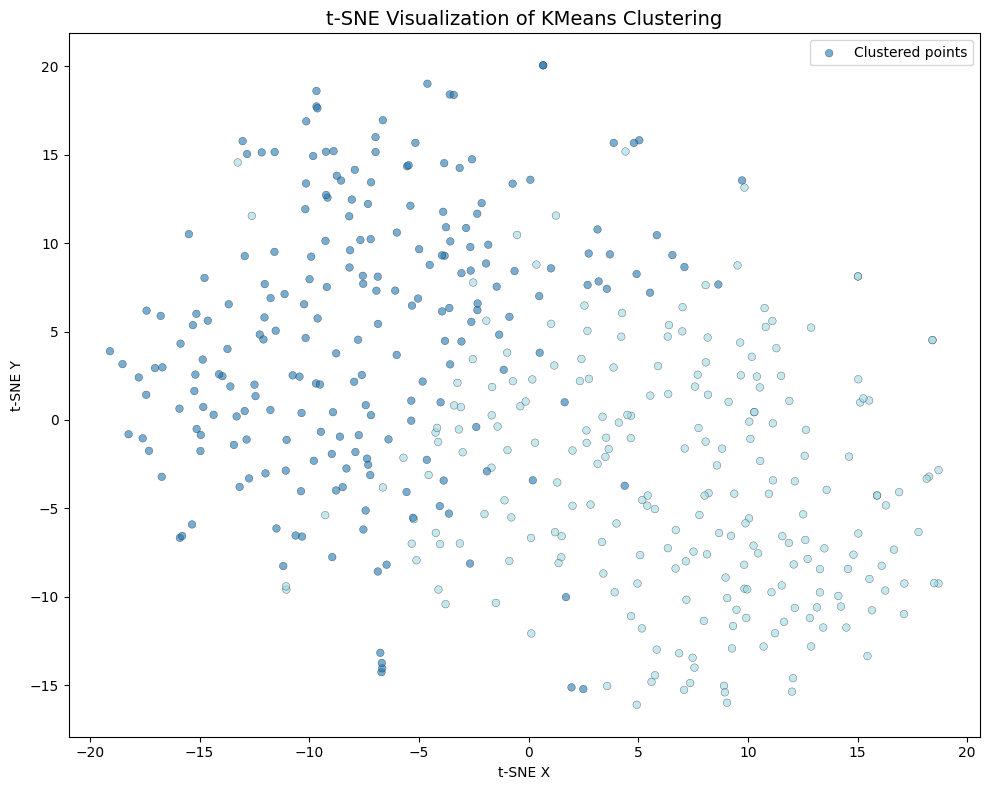

Silhouette index: 0.094
Problematic clustering — Cluster 0: lt, Cluster 1: lt
language_code_predicted
unknown      171575
en            57298
fr            17480
es            17028
de            14953
ko             6229
uncertain      5644
zh             5484
it             4490
nl             3926
ru             3859
pl             2991
cs             2726
sv             2553
el             2528
ja             2506
da             2267
fi             2135
no             2124
id             1695
tr             1559
th             1097
lt              809
ka              610
vi              591
lv              581
bg              536
hu              479
et              464
ar              400
he              109
pt               47
sl               18
km               16
ca                7
gl                3
uk                2
sk                2
ro                2
nn                2
wuu               1
af                1
eu                1
mg                1
la                

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


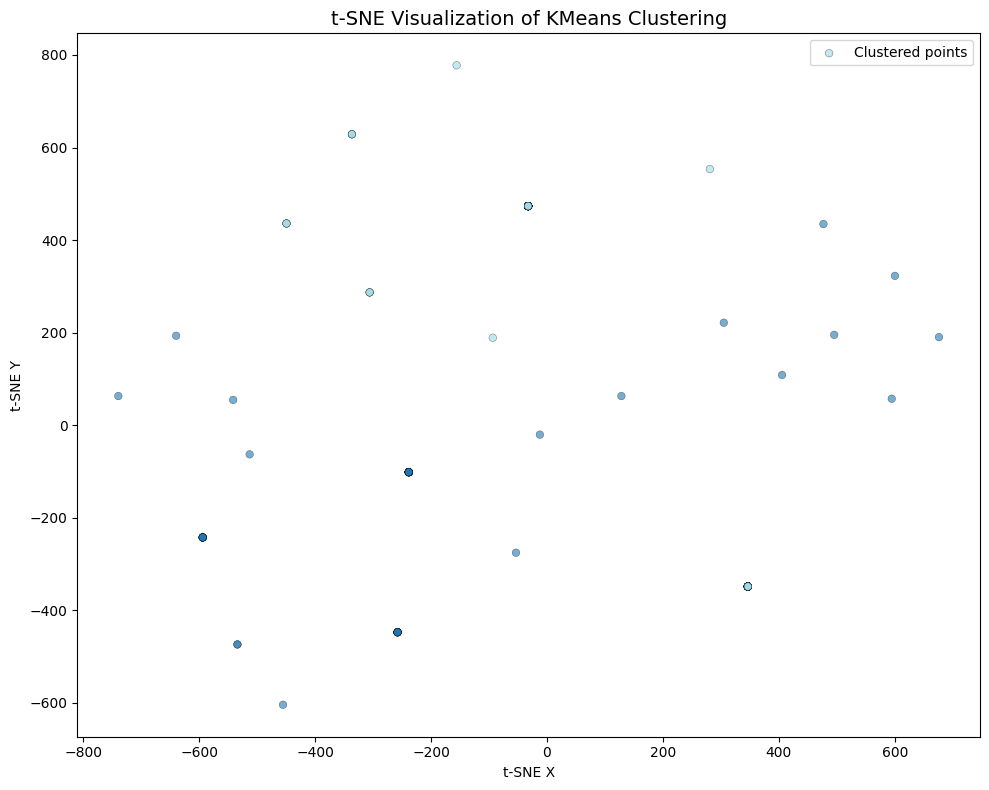

Silhouette index: 0.705
Proceeding with logistic regression. English cluster: 1
label
0    50
1    50
Name: count, dtype: int64
Confusion Matrix:
[[10  0]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        10
 Non-English       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Number of certain predictions: 100 / 100
language_code_predicted
unknown      171575
en            57298
fr            17480
es            17028
de            14953
ko             6229
uncertain      5644
zh             5484
it             4490
nl             3926
ru             3859
pl             2991
cs             2726
sv             2553
el             2528
ja             2506
da             2267
fi             2135
no             2124
id             1695
tr             1559

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


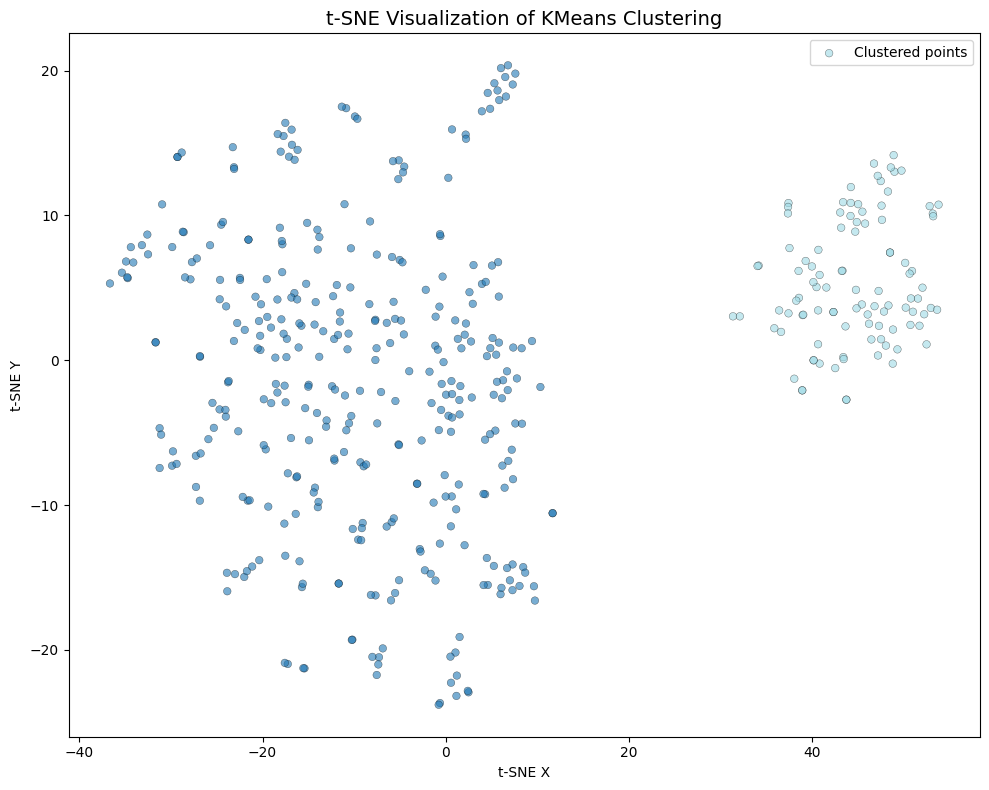

Silhouette index: 0.180
Proceeding with logistic regression. English cluster: 1
label
0    350
1    350
Name: count, dtype: int64
Confusion Matrix:
[[64  6]
 [ 0 70]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.91      0.96        70
 Non-English       0.92      1.00      0.96        70

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140

Number of certain predictions: 99 / 100
language_code_predicted
unknown      171575
en            57298
fr            17480
es            17028
de            14953
ko             6229
uncertain      5644
zh             5484
it             4490
nl             3926
ru             3859
pl             2991
cs             2726
sv             2553
el             2528
ja             2506
da             2267
fi             2135
no             2124
id             1695
tr             155

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


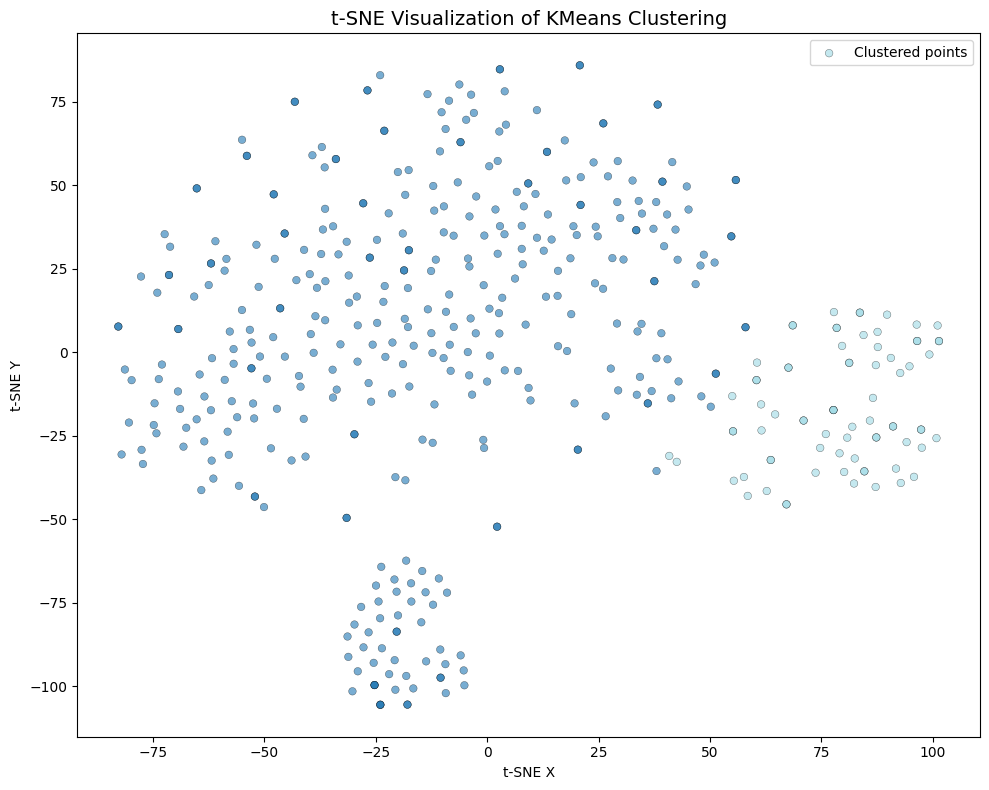

Silhouette index: 0.416
Proceeding with logistic regression. English cluster: 1
label
0    373
1    373
Name: count, dtype: int64
Confusion Matrix:
[[75  0]
 [ 0 75]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        75
 Non-English       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Number of certain predictions: 19 / 77
language_code_predicted
unknown      171575
en            57298
fr            17480
es            17028
de            14953
ko             6229
uncertain      5644
zh             5484
it             4490
nl             3926
ru             3859
pl             2991
cs             2726
sv             2553
el             2528
ja             2506
da             2267
fi             2135
no             2124
id             1695
tr             1559

In [96]:
countries = ["Lithuania"]

for country in countries:
    print(f"\n=== Processing country: {country} ===")
    
    # Get unique field names for this country
    country_df = df_binary_ml   
    unique_fields = country_df["field_name"].unique()
    
    for field in unique_fields:
        print(f"\nProcessing field: {field} for country: {country}")
        df_fasttext, problem = process_country_language_labeling(
            df_fasttext, country, field, df_english_rep, model_detect, country_language_counts
        )
        if problem is not None:
            problematic_clusters.append(problem)

print("\nProblematic clusters summary (country, field):")
print(problematic_clusters)



C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


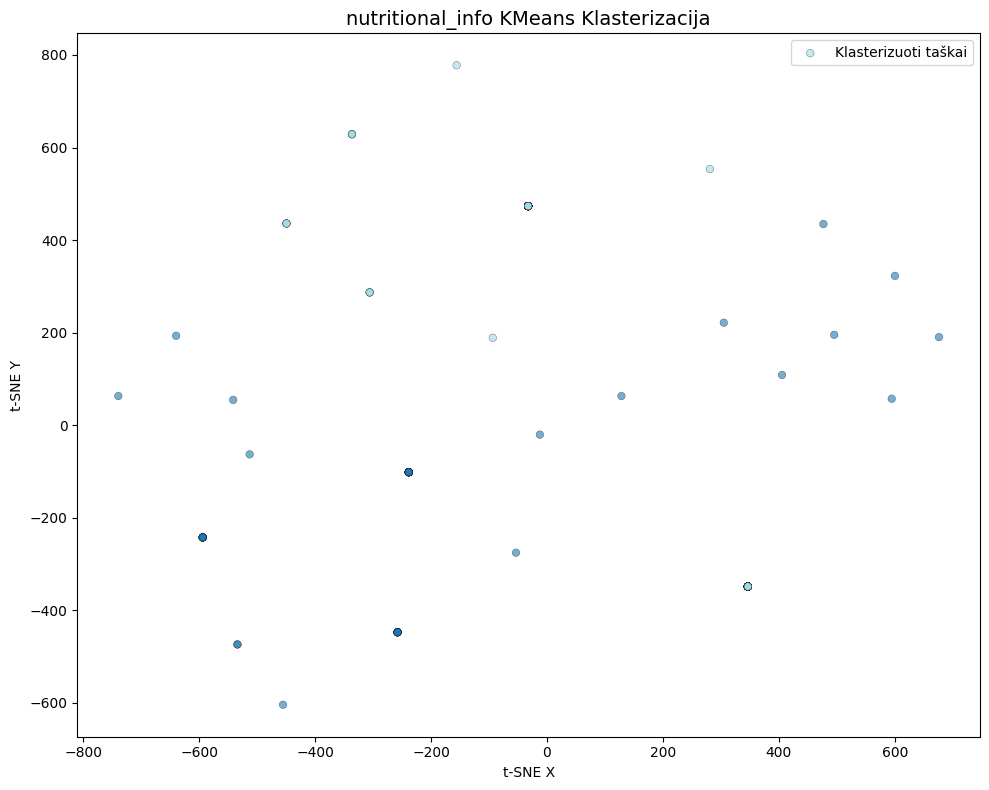

Silhouette index: 0.705
Confusion Matrix (aligned):
[[100   0]
 [  0  50]]
Accuracy: 100.00%

label
0    50
1    50
Name: count, dtype: int64
Confusion Matrix:
[[10  0]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        10
 Non-English       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Number of certain predictions: 100 / 100
Confusion Matrix:
        Pred 0  Pred 1
True 0     100       0
True 1       0       0

Only one class present (0). Skipping classification report.


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


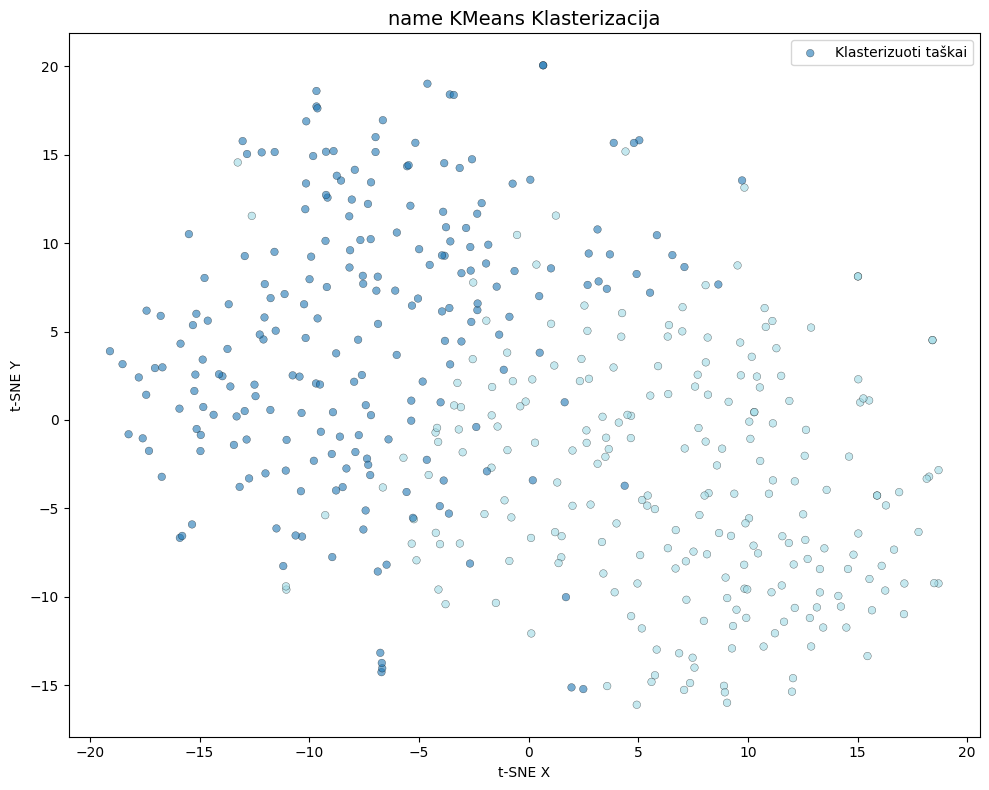

Silhouette index: 0.094
Confusion Matrix (aligned):
[[ 43  14]
 [178 215]]
Accuracy: 57.33%

label
0    229
1    229
Name: count, dtype: int64
Confusion Matrix:
[[43  3]
 [ 0 46]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.93      0.97        46
 Non-English       0.94      1.00      0.97        46

    accuracy                           0.97        92
   macro avg       0.97      0.97      0.97        92
weighted avg       0.97      0.97      0.97        92

Number of certain predictions: 70 / 221
Confusion Matrix:
        Pred 0  Pred 1
True 0      32       0
True 1      32       6

Classification Report:
              precision    recall  f1-score   support

     English     0.5000    1.0000    0.6667        32
 Non-English     1.0000    0.1579    0.2727        38

    accuracy                         0.5429        70
   macro avg     0.7500    0.5789    0.4697        70
weighted avg     0.7714    0.5429    0.4528   

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


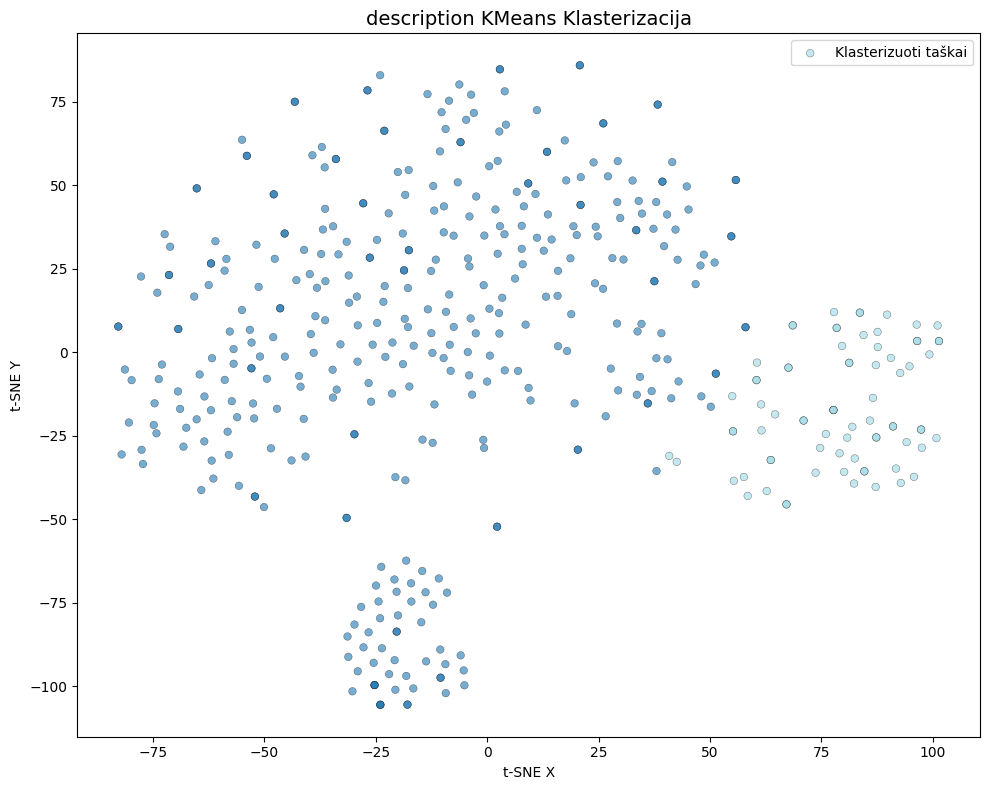

Silhouette index: 0.416
Confusion Matrix (aligned):
[[ 22   1]
 [ 55 372]]
Accuracy: 87.56%

label
0    373
1    373
Name: count, dtype: int64
Confusion Matrix:
[[75  0]
 [ 0 75]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00        75
 Non-English       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Number of certain predictions: 19 / 77
Confusion Matrix:
        Pred 0  Pred 1
True 0      12       0
True 1       6       1

Classification Report:
              precision    recall  f1-score   support

     English     0.6667    1.0000    0.8000        12
 Non-English     1.0000    0.1429    0.2500         7

    accuracy                         0.6842        19
   macro avg     0.8333    0.5714    0.5250        19
weighted avg     0.7895    0.6842    0.5974    

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


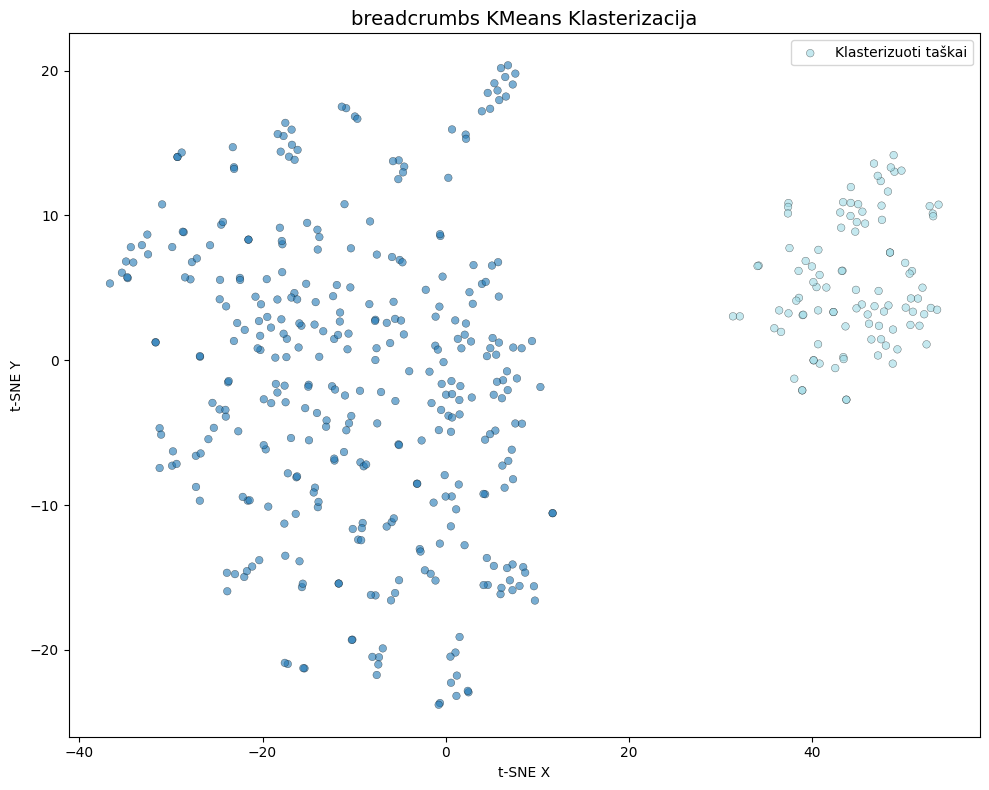

Silhouette index: 0.180
Confusion Matrix (aligned):
[[100   0]
 [  0 350]]
Accuracy: 100.00%

label
0    350
1    350
Name: count, dtype: int64
Confusion Matrix:
[[64  6]
 [ 0 70]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.91      0.96        70
 Non-English       0.92      1.00      0.96        70

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140

Number of certain predictions: 99 / 100
Confusion Matrix:
        Pred 0  Pred 1
True 0      99       0
True 1       0       0

Only one class present (0). Skipping classification report.


In [120]:
df = df_lithuania_labeled
#Lithuanian nutritional info
(
        df0_nutr,
        df1_nutr,
        top25_0,
        top25_1,
        should_continue,
        lang0,
        lang1
    ) = run_kmeans_clustering(df, "nutritional_info", 2, plot=True,initial_centroids=None, show_confusion=True)


clf, embedding_cols = train_balanced_language_classifier(df_english_rep, df0_nutr, field_name="nutritional_info")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, df1_nutr, low=0.3, high=0.7)

# Process 'name'
(
    df0_name,
    df1_name,
    top25_0_br,
    top25_1_br,
    should_continue_name, 
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "name", 2, plot=True,initial_centroids=None, show_confusion=True)

english_cluster = df0_name
non_english_cluster = df1_name

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="name")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)


# Process 'Description'
(
    df0_desc,
    df1_desc,
    top25_0_br,
    top25_1_br,
    should_continue_name,  # ignored
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "description", 2, plot=True,initial_centroids=None, show_confusion=True)

english_cluster = df1_desc
non_english_cluster = df0_desc

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="description")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)


# Process 'breadcrumbs'
(
    df0_br,
    df1_br,
    top25_0_br,
    top25_1_br,
    should_continue_name,  # ignored
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "breadcrumbs", 2, plot=True,initial_centroids=None, show_confusion=True)
english_cluster = df1_br
non_english_cluster = df0_br

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="breadcrumbs")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)



In [88]:
(
    df0,
    df1,
    top25_0,
    top25_1,
    should_continue,
    lang0,
    lang1
) = run_kmeans_clustering(
    df_fasttext[df_fasttext["country_name"] == "Lithuania"],  # Case-sensitive match
    "name",
    2,
    plot=False
)

print(top25_0)
print(top25_1)


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
šunims katėms pašaras sausas plaukų šampūnas kačių konservai skanėstas kremas kūno care šunų vištiena skanėstai gėrimas veido platinum color rankų colour cream body rinkinys royal žaislas sūris well done skonio
ekologiškas gyvūnų mišinys padažas kremas alus skonio putojantis veido plaukų dubenėlis doco katėms šunims ekologiški šokoladas vynas vanduo prosecco šepetėlis dydis mpets pašaras pavadėlis aliejus ekologiškos rimi pupelės rinkinys vytintos


In [113]:
df = df_fasttext[df_fasttext["country_name"] == "Lithuania"].copy()

# Process 'name'
(
    df0_name,
    df1_name,
    top25_0_br,
    top25_1_br,
    should_continue_name,  # ignored
    lang0_br,
    lang1_br
) = run_kmeans_clustering(df, "name", 2, plot=False)

english_cluster = df1_name
non_english_cluster = df0_name
non_english_lang = "lt"

df.loc[non_english_cluster.index, "language_code_predicted"] = non_english_lang

clf, embedding_cols = train_balanced_language_classifier(df_english_rep, non_english_cluster, field_name="name")
df_preds, df_uncertain = evaluate_confident_predictions_on_df(clf, english_cluster, low=0.3, high=0.7)

df.loc[df_preds[df_preds["y_pred_certain"] == 0].index, "language_code_predicted"] = "en"
df.loc[df_preds[df_preds["y_pred_certain"] == 1].index, "language_code_predicted"] = non_english_lang

df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)
df.loc[df_uncertain_fasttext.index, "language_code_predicted"] = df_uncertain_fasttext["language_code_predicted"]
df_fasttext.loc[df.index, "language_code_predicted"] = df["language_code_predicted"]

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette index: 0.094
label
0    221
1    221
Name: count, dtype: int64
Confusion Matrix:
[[42  3]
 [14 30]]

Classification Report:
              precision    recall  f1-score   support

     English       0.75      0.93      0.83        45
 Non-English       0.91      0.68      0.78        44

    accuracy                           0.81        89
   macro avg       0.83      0.81      0.81        89
weighted avg       0.83      0.81      0.81        89

Number of certain predictions: 150 / 229


**spejimai Kanados ir Lietuvos**

In [155]:
# 1. Filtruojam fastText tik Lietuvai
df_fasttext_lt = df_fasttext[df_fasttext["country_name"] == "Lithuania"].copy()

# 2. Atsirenkam reikalingus stulpelius (field_name ir retailer)
df_fasttext_lt_sel = df_fasttext_lt[['field_id', 'retailer', 'language_code_predicted']].copy()

# 3. Jungiame su df_binary_ml pagal field_name ir retailer
df_joined_lt = df_binary_ml.merge(
    df_fasttext_lt_sel,
    on=['field_id'],
    how='left',
    suffixes=('', '_fasttext')
)

# 4. Pasirenkam galutinius stulpelius
df_joined_final = df_joined_lt[['language_code', 'language_code_predicted', 'label',
                                'field_name', 'country_name', 'field_value', 'retailer', 'field_id']]


# 1. Filtruojam fastText tik Kanados įrašams
df_fasttext_ca = df_fasttext[df_fasttext["country_name"] == "Canada"].copy()

# 2. Atsirenkam reikalingus stulpelius
df_fasttext_ca_sel = df_fasttext_ca[['field_id', 'retailer', 'language_code_predicted']].copy()

# 3. Jungiame su švarintais Kanados duomenimis
df_joined_ca = df_combined_canada_clean_emb.merge(
    df_fasttext_ca_sel,
    on=['field_id'],
    how='left',
    suffixes=('', '_fasttext')
)

# 4. Galutiniai stulpeliai
df_joined_canada_final = df_joined_ca[['language_code', 'language_code_predicted', 'label',
                                       'field_name', 'country_name', 'field_value', 'retailer', 'field_id']]


# Combine Lithuanian and Canadian joined data
df_joined_combined = pd.concat([df_joined_final, df_joined_canada_final], ignore_index=True)

# Save to CSV
df_joined_combined.to_csv("language_predictions_lithuania_canada.csv", index=False)


**Isivertinimui atskirtai paleisti Kanados duomenys**

**Priskiriame trivelius atsakymus, manome nepagerintume, issaugojame galutinius spejimus**

In [117]:
# If df_fasttext is already loaded:
df_fasttext.loc[
    df_fasttext["country_name"].isin(["United Kingdom", "New Zealand", "Australia"]),
    "language_code_predicted"
] = "en"
#  Exclude embedding columns and 'field_value'
non_emb_cols = [col for col in df_fasttext.columns if not col.startswith("emb") and col != "field_value"]

# Create the filtered DataFrame
df_fasttext_non_emb = df_fasttext[non_emb_cols].copy()

# Save as Parquet
df_fasttext_non_emb.to_parquet("df_fasttext_non_emb.parquet", index=False)
print("✅ Saved as 'df_fasttext_non_emb.parquet' (no embeddings, no field_value)")





✅ Saved as 'df_fasttext_non_emb.parquet' (no embeddings, no field_value)


In [174]:
# Load the DataFrame
df = pd.read_parquet("df_fasttext_non_emb.parquet")

# Print counts of predicted language codes
print(df["language_code_predicted"].value_counts(dropna=False))

language_code_predicted
unknown      143053
en            85371
fr            17480
es            17028
de            14953
ko             6229
uncertain      5687
zh             5484
it             4491
nl             3926
ru             3859
pl             2992
cs             2726
sv             2553
el             2528
ja             2506
da             2267
fi             2135
no             2124
id             1695
tr             1559
lt             1212
th             1097
ka              610
vi              591
lv              581
bg              536
hu              479
et              464
ar              400
he              109
pt               47
sl               18
km               16
ca                7
gl                3
la                2
uk                2
sk                2
ro                2
nn                2
af                1
eu                1
mg                1
wuu               1
fy                1
eo                1
sr                1
lb              

C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


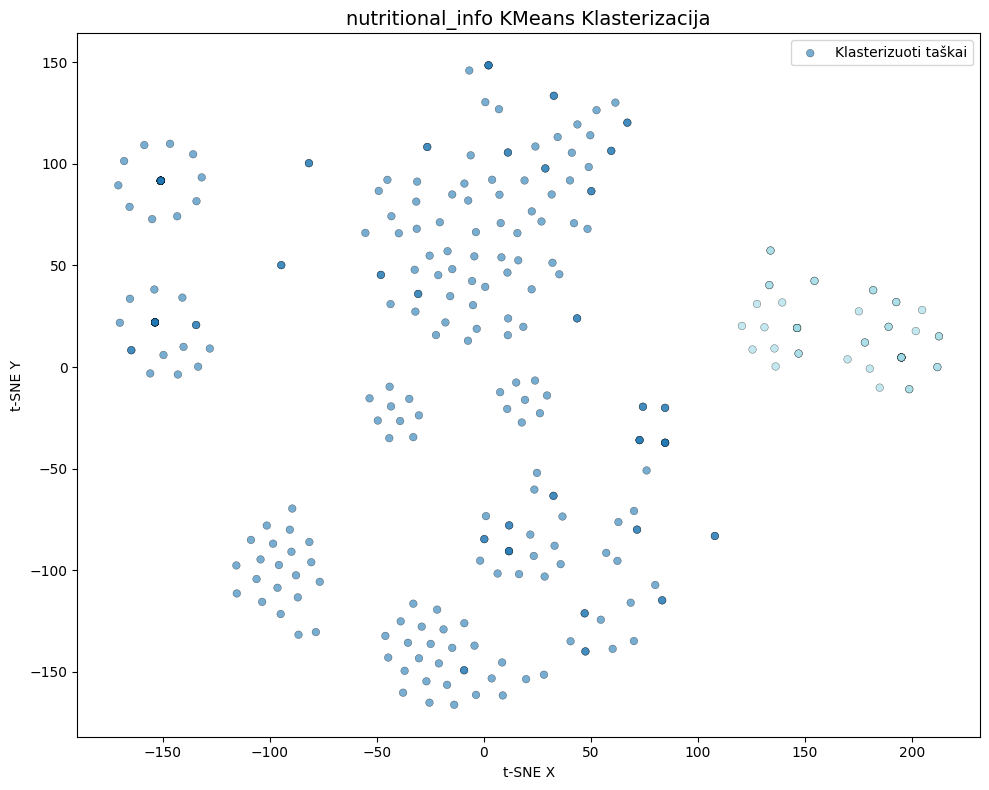

Silhouette index: 0.384
serving total grams calories saturated trans daily sodium protein cholesterol vitamin calcium carbohydrate iron size sugar potassium value sugars fiber dietary milligrams calorie values omega fibre amount based vitamina vitaminc
crude protein moisture mgkg fiber nutrient acid omega vitamin fibre calcium iukg phosphorus recognized essential aafco food profiles calories fatty ascorbic dinner analysis shown carbs taste magnesium taurine glucosamine potassium


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


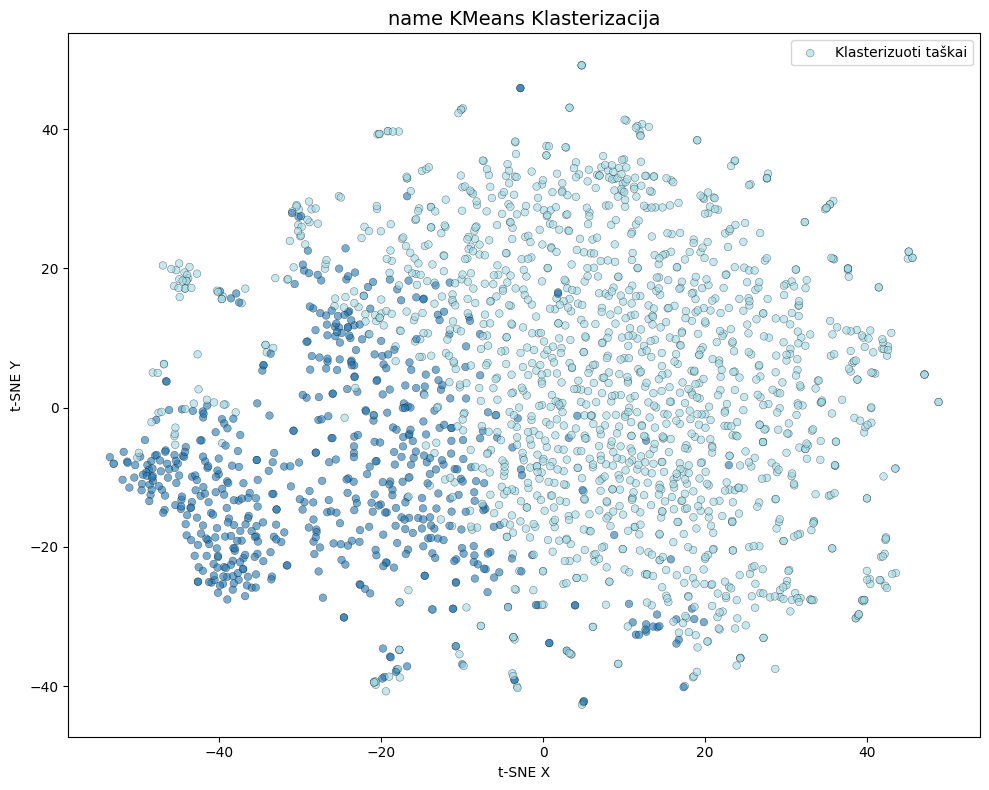

Silhouette index: 0.079
lindt chocolate lindor pour milk assorted truffles pack with white mascara douche julius mini sonya blanc eyeshadow palette lotion crème cream clinique moisturizer corps mains signature sauvignon blue huile visage
cream with pack body free gift skin food mini spray your hair black value chocolate travel face care hand powder adult makeup blue milk forever natural edition collection mask size


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


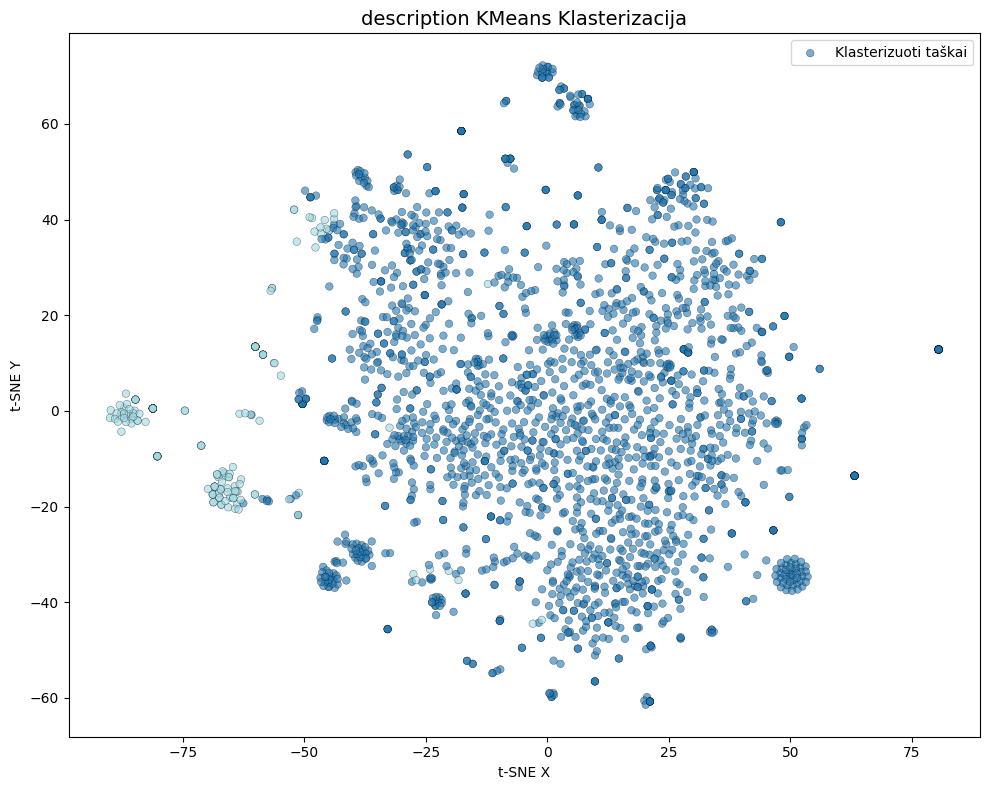

Silhouette index: 0.449
with your skin this product from that more natural protein span ingredients have free mask information plus made every hair blend vitamin unit face dogs last helps will help coffee
code detailed info parfum product designation huile alcohol pour size peau color country degree producer region promoting agent regulated avec grape variety dambiance dagrume cheveux votre extract sugar sodium origin


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


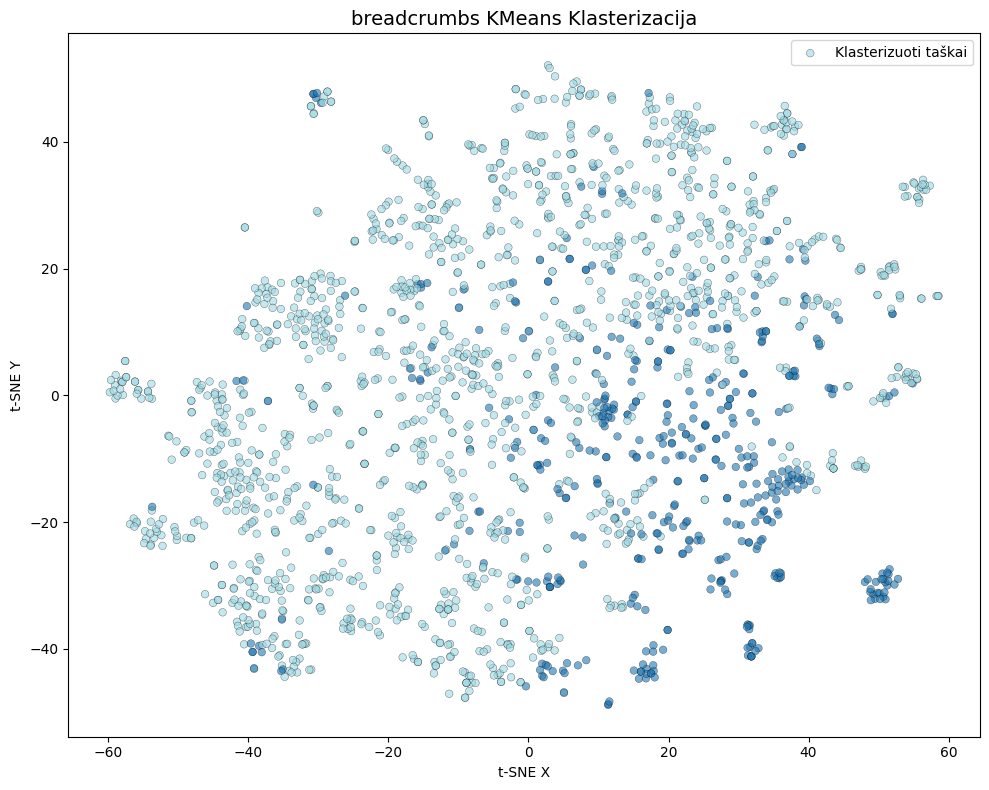

Silhouette index: 0.101
accessories shop lindt list pantry pour brands home itempositionname face skincare compliments fragrance gifting makeup accueil products canned plus corps household fragrances cleansers supplies chocolate skin moisturizers sauces product baking
home care beauty products body health skin makeup bath shop food natural hair grocery face supplies gifts personal shower sets fragrance accessories tools product snacks fresh pantry household frozen online


In [ ]:
# Subset Canada data
df_canada = df_canada_labeled

# Nutritional Info
(
    df0_nutr_can,
    df1_nutr_can,
    top25_0,
    top25_1,
    should_continue_nutr,
    lang0,
    lang1
) = run_kmeans_clustering(df_canada, "nutritional_info", 2, plot=True, show_confusion=True)

print(top25_0)
print(top25_1)

# Name
(
    df0_name_can,
    df1_name_can,
    top25_0,
    top25_1,
    should_continue_name,
    lang0,
    lang1
) = run_kmeans_clustering(df_canada, "name", 2, plot=True, show_confusion=True)

print(top25_0)
print(top25_1)
# Description
(
    df0_desc_can,
    df1_desc_can,
    top25_0,
    top25_1,
    should_continue_desc,
    lang0,
    lang1
) = run_kmeans_clustering(df_canada, "description", 2, plot=True, show_confusion=True)

print(top25_0)
print(top25_1)
# Breadcrumbs
(
    df0_br_can,
    df1_br_can,
    top25_0,
    top25_1,
    should_continue_br,
    lang0,
    lang1
) = run_kmeans_clustering(df_canada, "breadcrumbs", 2, plot=True, show_confusion=True)

print(top25_0)
print(top25_1)


In [ ]:
 
df = pd.read_csv("language_predictions_lithuania_canada.csv")
df_lt = df_joined_combined[df_joined_combined["country_name"] == "Lithuania"].copy()

df_ca =df_joined_combined[df_joined_combined["country_name"] == "Canada"].copy()


In [161]:
df_lt_certain = df_lt[df_lt["language_code_predicted"] != "uncertain"].copy()

# Sukuriam predicted_label: 0 jei "en", kitaip 1 (lietuvių)
df_lt_certain["predicted_label"] = df_lt_certain["language_code_predicted"].apply(lambda x: 0 if x == "en" else 1)

# Tikros ir prognozuotos etiketės
y_true = df_lt_certain["label"]
y_pred = df_lt_certain["predicted_label"]

# Metrikos
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["English (0)", "Lithuanian (1)"]))


Confusion matrix:
[[ 217   50]
 [   7 1164]]

Classification report:
                precision    recall  f1-score   support

   English (0)       0.97      0.81      0.88       267
Lithuanian (1)       0.96      0.99      0.98      1171

      accuracy                           0.96      1438
     macro avg       0.96      0.90      0.93      1438
  weighted avg       0.96      0.96      0.96      1438



In [171]:
df_ca["label"] = df_ca["label"].apply(
    lambda x: 1 - x if pd.notnull(x) else x
)

df_ca_certain = df_ca[df_ca["language_code_predicted"] != "uncertain"].copy()

# Sukuriam predicted_label: 0 jei "en", kitaip 1 (lietuvių)
df_ca_certain["predicted_label"] = df_ca_certain["language_code_predicted"].apply(lambda x: 0 if x == "en" else 1)

# Tikros ir prognozuotos etiketės
y_true = df_ca_certain["label"]
y_pred = df_ca_certain["predicted_label"]

# Metrikos
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["English (0)", "French (1)"]))


Confusion matrix:
[[6091  100]
 [  29  257]]

Classification report:
              precision    recall  f1-score   support

 English (0)       1.00      0.98      0.99      6191
  French (1)       0.72      0.90      0.80       286

    accuracy                           0.98      6477
   macro avg       0.86      0.94      0.89      6477
weighted avg       0.98      0.98      0.98      6477



In [ ]:
field_names = df_canada_labeled["field_name"].unique()
# Invert 0↔1 so that 0 = English, 1 = Non-English
df_canada_labeled["label"] = df_canada_labeled["label"].apply(
    lambda x: 1 - x if pd.notnull(x) else x
)

for field in field_names:
    print(f"\nProcessing field: {field}")

    # Get French training data (from df_fasttext)
    df_france = df_fasttext[
        (df_fasttext["country_name"] == "France") &
        (df_fasttext["language_code_predicted"] == "fr") &
        (df_fasttext["field_name"] == field)
    ]

    if df_france.empty:
        print(f"Skipping field '{field}' — no French data available.")
        continue

    # Subset labeled Canada data for this field
    df_can_field = df_canada_labeled[df_canada_labeled["field_name"] == field].copy()

    if df_can_field.empty:
        print(f"Skipping field '{field}' — no Canada data available.")
        continue

    # Train classifier using UK English + French
    clf, emb_cols = train_balanced_language_classifier(
        df_english_rep, df_france, field_name=field
    )

    # Predict on labeled Canadian data
    df_preds, df_uncertain = evaluate_confident_predictions_on_df(
        clf, df_can_field, low=0.3, high=0.7
    )

    # Predict uncertain ones using FastText (optional fallback)
    df_uncertain_fasttext = predict_fasttext_confident(df_uncertain, model_detect)

    # You can now compare df_preds["y_pred_certain"] vs df_can_field["label"]
    # Or print confusion matrix etc.



Processing field: description
label
0    5621
1    5621
Name: count, dtype: int64
Confusion Matrix:
[[1115   10]
 [   0 1124]]

Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00      1125
 Non-English       0.99      1.00      1.00      1124

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249

Number of certain predictions: 2144 / 2186
Confusion Matrix:
        Pred 0  Pred 1
True 0    2080      29
True 1       4      31

Classification Report:
              precision    recall  f1-score   support

     English     0.9981    0.9862    0.9921      2109
 Non-English     0.5167    0.8857    0.6526        35

    accuracy                         0.9846      2144
   macro avg     0.7574    0.9360    0.8224      2144
weighted avg     0.9902    0.9846    0.9866      2144


Processing field: breadcrumbs
label
0  